In [1]:
import os
import shutil
import pandas as pd
# import sh
#from pyspark.sql.functions import *
from pyspark.sql import functions as F
from pyspark.sql.types import *

In [2]:
import matplotlib.pyplot as plt

In [3]:
pd.set_option("max_colwidth", 100)

In [4]:
from google.cloud import storage

In [5]:
import os
import subprocess
from pyspark.sql.functions import *
from pyspark.sql.types import *

In [6]:
spark.conf.set("spark.sql.repl.eagerEval.enabled",True)

In [11]:
directory = 'gs://msca-bdp-students-bucket/shared_data/nukagvilia/tweets3'
# file = '*.parquet'
# path = directory + file
path = directory

In [12]:
cmd = 'hadoop fs -du -s -h ' + directory

p = subprocess.Popen(cmd, shell=True, stdout=subprocess.PIPE, stderr=subprocess.STDOUT, universal_newlines=True)
for line in p.stdout.readlines():
    print (line)
    
retval = p.wait()

16.1 G  16.1 G  gs://msca-bdp-students-bucket/shared_data/nukagvilia/tweets3



In [13]:
%%time

from pyspark.sql import SparkSession
# initialise sparkContext
spark = SparkSession.builder \
    .master('local') \
    .appName('myAppName') \
    .config('spark.executor.memory', '5gb') \
    .config("spark.cores.max", "6") \
    .getOrCreate()

sc = spark.sparkContext

# using SQLContext to read parquet file
from pyspark.sql import SQLContext
sqlContext = SQLContext(sc)

# to read parquet file
df = sqlContext.read.parquet(path)

CPU times: user 3.46 ms, sys: 3.94 ms, total: 7.39 ms
Wall time: 1.13 s


In [14]:
df.printSchema()

root
 |-- created_at: string (nullable = true)
 |-- id_str: string (nullable = true)
 |-- text: string (nullable = true)
 |-- entities: struct (nullable = true)
 |    |-- hashtags: array (nullable = true)
 |    |    |-- element: struct (containsNull = true)
 |    |    |    |-- indices: array (nullable = true)
 |    |    |    |    |-- element: long (containsNull = true)
 |    |    |    |-- text: string (nullable = true)
 |    |-- media: array (nullable = true)
 |    |    |-- element: struct (containsNull = true)
 |    |    |    |-- additional_media_info: struct (nullable = true)
 |    |    |    |    |-- description: string (nullable = true)
 |    |    |    |    |-- embeddable: boolean (nullable = true)
 |    |    |    |    |-- monetizable: boolean (nullable = true)
 |    |    |    |    |-- title: string (nullable = true)
 |    |    |    |-- description: string (nullable = true)
 |    |    |    |-- display_url: string (nullable = true)
 |    |    |    |-- expanded_url: string (nullable =

In [90]:
df.count()

16847876

In [14]:
df[['favorite_count']].describe()

summary,favorite_count
count,16847876
mean,0.0
stddev,0.0
min,0
max,0


In [18]:
df[['quote_count']].describe()

summary,quote_count
count,16847876
mean,0.0
stddev,0.0
min,0
max,0


In [19]:
df[['reply_count']].describe()

summary,reply_count
count,16847876
mean,0.0
stddev,0.0
min,0
max,0


In [19]:
df.select('user.favourites_count').describe()

summary,favourites_count
count,16847876
mean,51264.22480768496
stddev,94359.12607406022
min,0
max,3107041


#### Create df2 - dataframe with the useful columns

In [23]:
import pyspark.sql.functions as F
df2 = df.select\
(['created_at', 'id_str', 'text', 'entities', 'user', 'retweeted_status', 'retweet_count', 'favorite_count', 'quote_count', 'lang',\
 F.col("user.screen_name").alias("name"), F.col("user.location").alias("location"),  F.col("user.followers_count").alias('followers_count2'),\
 F.col("user.statuses_count").alias('statuses_count2'), F.col("coordinates.coordinates").alias('coord'), 'country1'])

In [10]:
#display(df2)

In [24]:
df2 = df2.filter(df2.lang == 'en')

In [25]:
df2.count()

16847876

In [25]:
df2 = df2.withColumn('retweet_count2', df2.retweeted_status.retweet_count)

In [26]:
df2 = df2.withColumn('quote_count2', df2.retweeted_status.quote_count)

In [27]:
df2 = df2.withColumn('favorite_count2', df2.retweeted_status.favorite_count)

In [20]:
#display(df2)

In [28]:
df2 = df2.fillna({'retweet_count2' : 0})
df2 = df2.fillna({'quote_count2' : 0})
df2 = df2.fillna({'favorite_count2' : 0})

In [29]:
df2 = df2.withColumn('verified', df2.user.verified)

In [30]:
df2 = df2.withColumn('screen_name', df2.user.screen_name)

In [31]:
df2 = df2.withColumn('retweet_quote', df2.retweet_count2 + df2.quote_count2)

In [32]:
df2 = df2.withColumn('username', df2['user.name'])

In [33]:
df2 = df2.withColumn('id', df2['user.id_str'])

In [34]:
fav_df1 = df2.groupBy('id').agg(sum('favorite_count2'))

In [99]:
fav_df1

id,sum(favorite_count2)
574432746,0
782787482957979648,1
2857659911,219173
1416790640168370176,860
29935317,0
1380350815,2491
3247474579,2979
93402546,24362
3160723585,131294
1327666400,7107


In [100]:
temp1_df = tweet_vol_df1.join(retweet_df1, tweet_vol_df1.id == retweet_df1.id, 'inner').select(tweet_vol_df1.id, \
                                                                                              tweet_vol_df1['count(text)'],retweet_df1['sum(retweet_quote)'])

In [101]:
temp1_df

id,count(text),sum(retweet_quote)
1000340071180943360,1,160
1000480061269700608,1,5853
1000480351905632258,11,7467
1000587623922987009,1,272
1000806617275949058,1,2599
1000939642546421760,1,3667
1000965128928440321,1,0
1000966048089165824,2,72690
1001118032314425344,1,1
1001349037965037570,2,119


In [102]:
temp2_df = temp1_df.join(fav_df1, temp1_df.id == fav_df1.id, 'inner').drop(temp1_df.id)

In [103]:
temp2_df

count(text),sum(retweet_quote),id,sum(favorite_count2)
1,160,1000340071180943360,216
1,5853,1000480061269700608,17556
11,7467,1000480351905632258,21148
1,272,1000587623922987009,216
1,2599,1000806617275949058,12146
1,3667,1000939642546421760,10834
1,0,1000965128928440321,0
2,72690,1000966048089165824,450373
1,1,1001118032314425344,1
2,119,1001349037965037570,620


In [104]:
df3 = df2.join(temp2_df, df2.id == temp2_df.id, 'inner').drop(df2.id)

In [108]:
df3 = df3.withColumnRenamed("count(text)","volume")

In [109]:
df3 = df3.withColumnRenamed('sum(retweet_quote)', 'total_retweet')

In [112]:
df3 = df3.withColumnRenamed('sum(favorite_count2)', 'total_favorites')

In [52]:
df2.filter(df2.country1.isNull()).count()  ## 16770337 null values, so, need to find a different column for location analysis

16770337

In [36]:
%%time

df2.write.format("parquet").\
mode('overwrite').\
save('gs://msca-bdp-students-bucket/shared_data/nukagvilia/tweets_df3_4')

In [88]:
retweets_df = df2.groupBy('id_str').agg(sum('retweet_quote'))

In [162]:
#retweets_df

In [90]:
tweet_vol_df = df2.groupBy('id_str').agg(count('text'))

In [163]:
#tweet_vol_df

In [95]:
vol_retweet_joined = tweet_vol_df.join(retweets_df, tweet_vol_df.id_str == rewteets_df.id_str, 'inner') \
                        .select(tweet_vol_df.id_str, tweet_vol_df['count(text)'], retweets_df['sum(retweet_quote)'])

In [97]:
#vol_retweet_joined

In [99]:
df2 = df2.join(vol_retweet_joined, df2.id_str == tweet_vol_df.id_str, 'inner').drop(tweet_vol_df.id_str)

In [101]:
#df2

In [106]:
favorites_df = df2.groupBy('id_str').sum('favorites_count2')

In [165]:
#favorites_df

In [108]:
df2 = df2.join(favorites_df, df2.id_str == favorites_df.id_str, 'inner').drop(favorites_df.id_str)

#### Re-import df3

In [53]:
directory = 'gs://msca-bdp-students-bucket/shared_data/nukagvilia/tweets_df3_2'
# file = '*.parquet'
# path = directory + file
path = directory

In [54]:
%%time

from pyspark.sql import SparkSession
# initialise sparkContext
spark = SparkSession.builder \
    .master('local') \
    .appName('myAppName') \
    .config('spark.executor.memory', '5gb') \
    .config("spark.cores.max", "6") \
    .getOrCreate()

sc = spark.sparkContext

# using SQLContext to read parquet file
from pyspark.sql import SQLContext
sqlContext = SQLContext(sc)

# to read parquet file
df = sqlContext.read.parquet(path)

CPU times: user 6.31 ms, sys: 391 µs, total: 6.7 ms
Wall time: 627 ms


In [55]:
df3 = df

In [56]:
df3

created_at,id_str,text,entities,user,retweeted_status,retweet_count,favorite_count,quote_count,lang,name,location,followers_count2,statuses_count2,coord,favorite_count2,retweet_count2,quote_count2,verified,screen_name,retweet_quote,username,volume,total_retweet,id,total_favorites
Sun Oct 17 21:20:...,1449847800511057923,RT @JeffereyJaxen...,"[[[[19, 28], Nebr...","[false, Fri May 2...","[,, Sun Oct 17 00...",0,0,0,en,Kryptoe2,null,112,2268,null,6973,2282,169,false,Kryptoe2,2451,Lo,3,9402,1000055420692631554,19062
Sun Oct 24 22:24:...,1452400540802064388,RT @prof_freedom:...,"[[],, [], [], [[1...","[false, Fri May 2...","[,, Wed Sep 15 15...",0,0,0,en,Kryptoe2,null,123,2337,null,9713,5926,104,false,Kryptoe2,6030,Lo,3,9402,1000055420692631554,19062
Tue Oct 19 18:18:...,1450526665659006985,RT @TonyHinton201...,"[[],, [], [], [[7...","[false, Fri May 2...","[,, Mon Oct 18 21...",0,0,0,en,Kryptoe2,null,114,2288,null,2376,895,26,false,Kryptoe2,921,Lo,3,9402,1000055420692631554,19062
Mon Oct 25 02:34:...,1452463422361194497,RT @mwrlxn: Covid...,"[[], [[, Osita Os...","[false, Fri May 2...","[,, Mon Oct 25 01...",0,0,0,en,mariocarima99,null,130,3982,null,1,1,0,false,mariocarima99,1,#2pac,1,1,1000066492417929218,1
Fri Nov 05 05:03:...,1456487308887314439,RT @PRMgal1: MGAL...,"[[[[33, 41], Covi...","[false, Fri May 2...","[,, Thu Nov 04 21...",0,0,0,en,Qussai_jukhadar,null,8602,11139,null,1,1,1,false,Qussai_jukhadar,2,Qussai | قصي,1,2,1000120579977109504,1
Wed Oct 27 00:01:...,1453149914595217413,RT @CINEOC: Grand...,"[[],, [], [], [[1...","[false, Mon Dec 2...","[,, Tue Oct 26 16...",0,0,0,en,lanaabsolut,Cayman Islands,680,11760,null,9,11,0,false,lanaabsolut,11,Alanis,1,11,100014303,9
Wed Oct 20 03:58:...,1450672640600027136,RT @ktjos88: @MFo...,"[[],, [], [], [[3...","[false, Sat May 2...","[,, Tue Oct 19 21...",0,0,0,en,freedomfirs1,Arkansas/mississippi,191,3946,null,21,6,0,false,freedomfirs1,6,stan,1,6,1000219563814998016,21
Wed Oct 27 00:58:...,1453164084636045315,RT @kylegriffin1:...,"[[],, [], [], [[3...","[false, Mon Dec 2...","[,, Tue Oct 26 20...",0,0,0,en,PaigeKinnaird,New York State,298,5199,null,16017,2743,412,false,PaigeKinnaird,3155,Paige Kinnaird,2,5708,100033913,23085
Wed Oct 27 00:58:...,1453164145168297984,RT @DrLeanaWen: B...,"[[[[102, 110], co...","[false, Mon Dec 2...","[,, Tue Oct 26 20...",0,0,0,en,PaigeKinnaird,New York State,298,5200,null,7068,1748,805,false,PaigeKinnaird,2553,Paige Kinnaird,2,5708,100033913,23085
Tue Nov 09 17:55:...,1458131165001523208,RT @AkronJackson:...,"[[],, [], [], [[1...","[false, Sat May 2...","[,, Tue Nov 09 17...",0,0,0,en,CapitalAreaBB,"Columbus, OH",468,8533,null,113,9,1,false,CapitalAreaBB,10,Capital Area Brow...,2,103,1000414587232145409,645


Get the average ratio of total like count to total retweet count 

In [10]:
infl_temp = df3.select('total_favorites', 'total_retweet', df3.total_favorites/df3.total_retweet)

In [12]:
infl_temp.agg({'(total_favorites / total_retweet)': 'avg'}).show()   # 3.1744717425693736

+--------------------------------------+
|avg((total_favorites / total_retweet))|
+--------------------------------------+
|                    3.1744717425693736|
+--------------------------------------+



In [38]:
df3 = df3.withColumn('influence_score', (df3.total_favorites + 3*df3.total_retweet)/df3.volume)

In [39]:
df3

created_at,id_str,text,entities,user,retweeted_status,retweet_count,favorite_count,quote_count,lang,name,location,followers_count2,statuses_count2,coord,favorite_count2,retweet_count2,quote_count2,verified,screen_name,retweet_quote,username,volume,total_retweet,id,total_favorites,influence_score
Sun Oct 17 21:20:...,1449847800511057923,RT @JeffereyJaxen...,"[[[[19, 28], Nebr...","[false, Fri May 2...","[,, Sun Oct 17 00...",0,0,0,en,Kryptoe2,null,112,2268,null,6973,2282,169,false,Kryptoe2,2451,Lo,3,9402,1000055420692631554,19062,15756.0
Sun Oct 24 22:24:...,1452400540802064388,RT @prof_freedom:...,"[[],, [], [], [[1...","[false, Fri May 2...","[,, Wed Sep 15 15...",0,0,0,en,Kryptoe2,null,123,2337,null,9713,5926,104,false,Kryptoe2,6030,Lo,3,9402,1000055420692631554,19062,15756.0
Tue Oct 19 18:18:...,1450526665659006985,RT @TonyHinton201...,"[[],, [], [], [[7...","[false, Fri May 2...","[,, Mon Oct 18 21...",0,0,0,en,Kryptoe2,null,114,2288,null,2376,895,26,false,Kryptoe2,921,Lo,3,9402,1000055420692631554,19062,15756.0
Mon Oct 25 02:34:...,1452463422361194497,RT @mwrlxn: Covid...,"[[], [[, Osita Os...","[false, Fri May 2...","[,, Mon Oct 25 01...",0,0,0,en,mariocarima99,null,130,3982,null,1,1,0,false,mariocarima99,1,#2pac,1,1,1000066492417929218,1,4.0
Fri Nov 05 05:03:...,1456487308887314439,RT @PRMgal1: MGAL...,"[[[[33, 41], Covi...","[false, Fri May 2...","[,, Thu Nov 04 21...",0,0,0,en,Qussai_jukhadar,null,8602,11139,null,1,1,1,false,Qussai_jukhadar,2,Qussai | قصي,1,2,1000120579977109504,1,7.0
Wed Oct 27 00:01:...,1453149914595217413,RT @CINEOC: Grand...,"[[],, [], [], [[1...","[false, Mon Dec 2...","[,, Tue Oct 26 16...",0,0,0,en,lanaabsolut,Cayman Islands,680,11760,null,9,11,0,false,lanaabsolut,11,Alanis,1,11,100014303,9,42.0
Wed Oct 20 03:58:...,1450672640600027136,RT @ktjos88: @MFo...,"[[],, [], [], [[3...","[false, Sat May 2...","[,, Tue Oct 19 21...",0,0,0,en,freedomfirs1,Arkansas/mississippi,191,3946,null,21,6,0,false,freedomfirs1,6,stan,1,6,1000219563814998016,21,39.0
Wed Oct 27 00:58:...,1453164084636045315,RT @kylegriffin1:...,"[[],, [], [], [[3...","[false, Mon Dec 2...","[,, Tue Oct 26 20...",0,0,0,en,PaigeKinnaird,New York State,298,5199,null,16017,2743,412,false,PaigeKinnaird,3155,Paige Kinnaird,2,5708,100033913,23085,20104.5
Wed Oct 27 00:58:...,1453164145168297984,RT @DrLeanaWen: B...,"[[[[102, 110], co...","[false, Mon Dec 2...","[,, Tue Oct 26 20...",0,0,0,en,PaigeKinnaird,New York State,298,5200,null,7068,1748,805,false,PaigeKinnaird,2553,Paige Kinnaird,2,5708,100033913,23085,20104.5
Tue Nov 09 17:55:...,1458131165001523208,RT @AkronJackson:...,"[[],, [], [], [[1...","[false, Sat May 2...","[,, Tue Nov 09 17...",0,0,0,en,CapitalAreaBB,"Columbus, OH",468,8533,null,113,9,1,false,CapitalAreaBB,10,Capital Area Brow...,2,103,1000414587232145409,645,477.0


Count verified users

In [13]:
users = df3.select('id', 'verified').distinct()

In [14]:
users

id,verified
1011662636646322176,false
1044354712710123520,false
1081633044522508288,false
1092146148402495491,false
109672193,false
1119941,false
1128831841803223040,false
1177759317484662784,false
1196583561752719372,false
1214539707721211904,false


In [15]:
verified = users.filter(users.verified == 'true')

In [16]:
verified.count()

58081

### Fix the Date Column

In [57]:
df3 = df3.withColumn('year', substring('created_at', 26, 5))\
    .withColumn('month', substring('created_at', 4, 4))\
    .withColumn('week_day', substring('created_at', 0, 3))\
    .withColumn('day', substring('created_at', 8, 3))

In [58]:
df3 = df3.withColumn('new_date', concat_ws('-', col('year'), col('month'), col('day')))

In [59]:
df3 = df3.withColumn('new_date', regexp_replace(col("new_date"), " ", ""))

In [60]:
df3 = df3.withColumn("date_form",from_unixtime(unix_timestamp(col("new_date"),'yyyy-MMM-d'),'yyyy-MM-dd'))

In [61]:
from pyspark.sql.types import DateType
df3 = df3.withColumn('date',df3['date_form'].cast(DateType()))

In [62]:
display(df3)

created_at,id_str,text,entities,user,retweeted_status,retweet_count,favorite_count,quote_count,lang,name,location,followers_count2,statuses_count2,coord,favorite_count2,retweet_count2,quote_count2,verified,screen_name,retweet_quote,username,volume,total_retweet,id,total_favorites,year,month,week_day,day,new_date,date_form,date
Sun Oct 17 21:20:...,1449847800511057923,RT @JeffereyJaxen...,"[[[[19, 28], Nebr...","[false, Fri May 2...","[,, Sun Oct 17 00...",0,0,0,en,Kryptoe2,null,112,2268,null,6973,2282,169,false,Kryptoe2,2451,Lo,3,9402,1000055420692631554,19062,2021,Oct,Sun,17,2021-Oct-17,2021-10-17,2021-10-17
Sun Oct 24 22:24:...,1452400540802064388,RT @prof_freedom:...,"[[],, [], [], [[1...","[false, Fri May 2...","[,, Wed Sep 15 15...",0,0,0,en,Kryptoe2,null,123,2337,null,9713,5926,104,false,Kryptoe2,6030,Lo,3,9402,1000055420692631554,19062,2021,Oct,Sun,24,2021-Oct-24,2021-10-24,2021-10-24
Tue Oct 19 18:18:...,1450526665659006985,RT @TonyHinton201...,"[[],, [], [], [[7...","[false, Fri May 2...","[,, Mon Oct 18 21...",0,0,0,en,Kryptoe2,null,114,2288,null,2376,895,26,false,Kryptoe2,921,Lo,3,9402,1000055420692631554,19062,2021,Oct,Tue,19,2021-Oct-19,2021-10-19,2021-10-19
Mon Oct 25 02:34:...,1452463422361194497,RT @mwrlxn: Covid...,"[[], [[, Osita Os...","[false, Fri May 2...","[,, Mon Oct 25 01...",0,0,0,en,mariocarima99,null,130,3982,null,1,1,0,false,mariocarima99,1,#2pac,1,1,1000066492417929218,1,2021,Oct,Mon,25,2021-Oct-25,2021-10-25,2021-10-25
Fri Nov 05 05:03:...,1456487308887314439,RT @PRMgal1: MGAL...,"[[[[33, 41], Covi...","[false, Fri May 2...","[,, Thu Nov 04 21...",0,0,0,en,Qussai_jukhadar,null,8602,11139,null,1,1,1,false,Qussai_jukhadar,2,Qussai | قصي,1,2,1000120579977109504,1,2021,Nov,Fri,05,2021-Nov-05,2021-11-05,2021-11-05
Wed Oct 27 00:01:...,1453149914595217413,RT @CINEOC: Grand...,"[[],, [], [], [[1...","[false, Mon Dec 2...","[,, Tue Oct 26 16...",0,0,0,en,lanaabsolut,Cayman Islands,680,11760,null,9,11,0,false,lanaabsolut,11,Alanis,1,11,100014303,9,2021,Oct,Wed,27,2021-Oct-27,2021-10-27,2021-10-27
Wed Oct 20 03:58:...,1450672640600027136,RT @ktjos88: @MFo...,"[[],, [], [], [[3...","[false, Sat May 2...","[,, Tue Oct 19 21...",0,0,0,en,freedomfirs1,Arkansas/mississippi,191,3946,null,21,6,0,false,freedomfirs1,6,stan,1,6,1000219563814998016,21,2021,Oct,Wed,20,2021-Oct-20,2021-10-20,2021-10-20
Wed Oct 27 00:58:...,1453164084636045315,RT @kylegriffin1:...,"[[],, [], [], [[3...","[false, Mon Dec 2...","[,, Tue Oct 26 20...",0,0,0,en,PaigeKinnaird,New York State,298,5199,null,16017,2743,412,false,PaigeKinnaird,3155,Paige Kinnaird,2,5708,100033913,23085,2021,Oct,Wed,27,2021-Oct-27,2021-10-27,2021-10-27
Wed Oct 27 00:58:...,1453164145168297984,RT @DrLeanaWen: B...,"[[[[102, 110], co...","[false, Mon Dec 2...","[,, Tue Oct 26 20...",0,0,0,en,PaigeKinnaird,New York State,298,5200,null,7068,1748,805,false,PaigeKinnaird,2553,Paige Kinnaird,2,5708,100033913,23085,2021,Oct,Wed,27,2021-Oct-27,2021-10-27,2021-10-27
Tue Nov 09 17:55:...,1458131165001523208,RT @AkronJackson:...,"[[],, [], [], [[1...","[false, Sat May 2...","[,, Tue Nov 09 17...",0,0,0,en,CapitalAreaBB,"Columbus, OH",468,8533,null,113,9,1,false,CapitalAreaBB,10,Capital Area Brow...,2,103,1000414587232145409,645,2021,Nov,Tue,09,2021-Nov-09,2021-11-09,2021-11-09


Find the date range

In [87]:
# Latest date
df3.select('date').orderBy('date', ascending = False)

date
2021-11-12
2021-11-12
2021-11-12
2021-11-12
2021-11-12
2021-11-12
2021-11-12
2021-11-12
2021-11-12
2021-11-12


In [88]:
# Earliest date
df3.select('date').orderBy('date', ascending = True)

date
2021-10-15
2021-10-15
2021-10-15
2021-10-15
2021-10-15
2021-10-15
2021-10-15
2021-10-15
2021-10-15
2021-10-15


#### Get Organizations

In [16]:
df3 = df3.withColumn('description', df3.user.description)

In [17]:
df3 = df3.withColumn('description2', lower(df3.description))

In [18]:
df3 = df3.fillna({'total_favorites' : 0})
df3 = df3.fillna({'total_retweet' : 0})

In [25]:
#favs = df3.select('total_favorites').toPandas()

In [25]:
#favs.median()  #25501

total_favorites    25501.0
dtype: float64

In [26]:
#med_fav = 25501

In [19]:
df3 = df3.withColumn('organization', 
                F.when(df3.verified == 'false', 'Other') \
                .when( (df3.description2.contains('clinic')) \
                      | (df3.description2.contains('medic')) \
                      | (df3.description2.contains('nurse')) \
                      | (df3.description2.contains('health')) | (df3.description2.contains('care')) \
                      | (df3.description2.contains('patient')) | (df3.description2.contains('disease')) \
                      | (df3.description2.contains('vaccine')) | (df3.description2.contains('cancer')) \
                      | (df3.description2.contains('illness')) | (df3.description2.contains('aids')) \
                      | (df3.description2.contains('physician')) | (df3.description2.contains('emergency')), 'Health' ) \
                .when( (df3.description2.contains('democra')) | (df3.description2.contains('republican')) | (df3.description2.contains('party')) \
                      | (df3.description2.contains('gov')) | (df3.description2.contains('senat')) \
                      | (df3.description2.contains('district')) | (df3.description2.contains('congress')) \
                      | (df3.description2.contains('chief')) | (df3.description2.contains('elect')) \
                      | (df3.description2.contains('mayor')) | (df3.description2.contains('serve')) \
                      | (df3.description2.contains('parliament')) | (df3.description2.contains(' mp ')), 'Governmental') \
                     .when(  (df3.description2.contains('news')) \
                      | (df3.description2.contains('journal')) | (df3.description2.contains('report')) | (df3.description2.contains('cover')) | (df3.description2.contains('stories'))\
                                                                                                                          | (df3.description2.contains('times')) | (df3.description2.contains('tv'))\
                                                                                                                          | (df3.description2.contains('channel')) | (df3.description2.contains(' fm ')) \
                                                                                                                          | (df3.description2.contains('post')) | (df3.description2.contains('magazine')) \
                                                                                                                          | (df3.description2.contains('station')) | (df3.description2.contains('tribune')) \
                                                                                                                          | (df3.description2.contains('pbs')) | (df3.description2.contains('insider')) \
                                                                                                                          | (df3.description2.contains('abc')) | (df3.description2.contains('media')) \
                                                                                                                          | (df3.description2.contains('gazette')) | (df3.description2.contains('edit')) \
                                                                                                                          | (df3.description2.contains('daily')) | (df3.description2.contains('column')), 'News')\
                     .when(((df3.description2.contains('actor')) & (df3.followers_count2 > 30000))\
                           | ((df3.description2.contains('player')) & (df3.followers_count2 > 30000))  \
                           | ((df3.description2.contains('writer')) & (df3.followers_count2 > 30000)) \
                           | ((df3.description2.contains('actress')) & (df3.followers_count2 > 30000)) \
                           | ((df3.description2.contains('singer')) & (df3.followers_count2 > 30000)) \
                           | ((df3.description2.contains('writer')) & (df3.followers_count2 > 30000)), 'Celebrity')\
                     #.when(df3.description2.contains('organization'), 'Other') \
                     .when(df3.followers_count2 >= 5000, 'Influencer')
                    
                )                    


In [50]:
df3 = df3.fillna({'organization' : 'Other'})

In [45]:
df3.groupBy('organization').count()

organization,count
Influencer,81391
Health,64192
Other,16400461
Governmental,43246
Celebrity,3198
News,255388


In [ ]:
# %%time

# df3.write.format("parquet").\
# mode('overwrite').\
# save('gs://msca-bdp-students-bucket/shared_data/nukagvilia/tweets_df3_org')

CPU times: user 63.9 ms, sys: 13.7 ms, total: 77.6 ms
Wall time: 5min 55s


In [51]:
df3

created_at,id_str,text,entities,user,retweeted_status,retweet_count,favorite_count,quote_count,lang,name,location,followers_count2,statuses_count2,coord,favorite_count2,retweet_count2,quote_count2,verified,screen_name,retweet_quote,username,volume,total_retweet,id,total_favorites,influence_score,year,month,week_day,day,new_date,date_form,date,description,description2,organization
Sun Oct 17 21:20:...,1449847800511057923,RT @JeffereyJaxen...,"[[[[19, 28], Nebr...","[false, Fri May 2...","[,, Sun Oct 17 00...",0,0,0,en,Kryptoe2,null,112,2268,null,6973,2282,169,false,Kryptoe2,2451,Lo,3,9402,1000055420692631554,19062,15756.0,2021,Oct,Sun,17,2021-Oct-17,2021-10-17,2021-10-17,"""When the mind is...","""when the mind is...",Other
Sun Oct 24 22:24:...,1452400540802064388,RT @prof_freedom:...,"[[],, [], [], [[1...","[false, Fri May 2...","[,, Wed Sep 15 15...",0,0,0,en,Kryptoe2,null,123,2337,null,9713,5926,104,false,Kryptoe2,6030,Lo,3,9402,1000055420692631554,19062,15756.0,2021,Oct,Sun,24,2021-Oct-24,2021-10-24,2021-10-24,"""The eyes are use...","""the eyes are use...",Other
Tue Oct 19 18:18:...,1450526665659006985,RT @TonyHinton201...,"[[],, [], [], [[7...","[false, Fri May 2...","[,, Mon Oct 18 21...",0,0,0,en,Kryptoe2,null,114,2288,null,2376,895,26,false,Kryptoe2,921,Lo,3,9402,1000055420692631554,19062,15756.0,2021,Oct,Tue,19,2021-Oct-19,2021-10-19,2021-10-19,"""When the mind is...","""when the mind is...",Other
Mon Oct 25 02:34:...,1452463422361194497,RT @mwrlxn: Covid...,"[[], [[, Osita Os...","[false, Fri May 2...","[,, Mon Oct 25 01...",0,0,0,en,mariocarima99,null,130,3982,null,1,1,0,false,mariocarima99,1,#2pac,1,1,1000066492417929218,1,4.0,2021,Oct,Mon,25,2021-Oct-25,2021-10-25,2021-10-25,null,null,Other
Fri Nov 05 05:03:...,1456487308887314439,RT @PRMgal1: MGAL...,"[[[[33, 41], Covi...","[false, Fri May 2...","[,, Thu Nov 04 21...",0,0,0,en,Qussai_jukhadar,null,8602,11139,null,1,1,1,false,Qussai_jukhadar,2,Qussai | قصي,1,2,1000120579977109504,1,7.0,2021,Nov,Fri,05,2021-Nov-05,2021-11-05,2021-11-05,‏‏باحث في الشأن ا...,‏‏باحث في الشأن ا...,Other
Wed Oct 27 00:01:...,1453149914595217413,RT @CINEOC: Grand...,"[[],, [], [], [[1...","[false, Mon Dec 2...","[,, Tue Oct 26 16...",0,0,0,en,lanaabsolut,Cayman Islands,680,11760,null,9,11,0,false,lanaabsolut,11,Alanis,1,11,100014303,9,42.0,2021,Oct,Wed,27,2021-Oct-27,2021-10-27,2021-10-27,null,null,Other
Wed Oct 20 03:58:...,1450672640600027136,RT @ktjos88: @MFo...,"[[],, [], [], [[3...","[false, Sat May 2...","[,, Tue Oct 19 21...",0,0,0,en,freedomfirs1,Arkansas/mississippi,191,3946,null,21,6,0,false,freedomfirs1,6,stan,1,6,1000219563814998016,21,39.0,2021,Oct,Wed,20,2021-Oct-20,2021-10-20,2021-10-20,Enjoy conservativ...,enjoy conservativ...,Other
Wed Oct 27 00:58:...,1453164084636045315,RT @kylegriffin1:...,"[[],, [], [], [[3...","[false, Mon Dec 2...","[,, Tue Oct 26 20...",0,0,0,en,PaigeKinnaird,New York State,298,5199,null,16017,2743,412,false,PaigeKinnaird,3155,Paige Kinnaird,2,5708,100033913,23085,20104.5,2021,Oct,Wed,27,2021-Oct-27,2021-10-27,2021-10-27,A ruckus maker cr...,a ruckus maker cr...,Other
Wed Oct 27 00:58:...,1453164145168297984,RT @DrLeanaWen: B...,"[[[[102, 110], co...","[false, Mon Dec 2...","[,, Tue Oct 26 20...",0,0,0,en,PaigeKinnaird,New York State,298,5200,null,7068,1748,805,false,PaigeKinnaird,2553,Paige Kinnaird,2,5708,100033913,23085,20104.5,2021,Oct,Wed,27,2021-Oct-27,2021-10-27,2021-10-27,A ruckus maker cr...,a ruckus maker cr...,Other
Tue Nov 09 17:55:...,1458131165001523208,RT @AkronJackson:...,"[[],, [], [], [[1...","[false, Sat May 2...","[,, Tue Nov 09 17...",0,0,0,en,CapitalAreaBB,"Columbus, OH",468,8533,null,113,9,1,false,CapitalAreaBB,10,Capital Area Brow...,2,103,1000414587232145409,645,477.0,2021,Nov,Tue,09,2021-Nov-09,2021-11-09,2021-11-09,@BrownsBackers ch...,@brownsbackers ch...,Other


#### Get the location column

In [63]:
df3 = df3.withColumn('location1', lower(df3.location))

In [64]:
df3 = df3.withColumn('location2', 
                    F.when((df3.location1.contains('uk')) | (df3.location1.contains('united kingdom')) \
                           | (df3.location1.contains('england')) | (df3.location1.contains('london')) \
                           | (df3.location1.contains('glasgow')) | (df3.location1.contains('liverpool')) \
                           | (df3.location1.contains('birmingham')) | (df3.location1.contains('edinburgh')) \
                           | (df3.location1.contains('scottland')) | (df3.location1.contains('wales')) \
                           | (df3.location1.contains('ireland')) | (df3.location1.contains('u.k')) \
                           | (df3.location1.contains('oxford')) | (df3.location1.contains('bristol')) \
                           | (df3.location1.contains('essex')) | (df3.location1.contains('surrey')) \
                           | (df3.location1.contains('sussex')), 'UK' ) \
                     .when((df3.location1.contains('ny')) | (df3.location1.contains('new york')) \
                           | (df3.location1.contains('nyc')) | (df3.location1.contains('buffalo')) \
                           | (df3.location1.contains('albany')) | (df3.location1.contains('rochester')) \
                           | (df3.location1.contains('troy')), 'US - New York' ) \
                     .when((df3.location1.contains('tx')) | (df3.location1.contains('texas')) \
                           | (df3.location1.contains('houston')) | (df3.location1.contains('austin')) \
                           | (df3.location1.contains('dallas')) | (df3.location1.contains('arlington')) \
                           | (df3.location1.contains('san antonio')), 'US - Texas')\
                     .when((df3.location1.contains('florida')) | (df3.location1.contains('fl')) \
                           | (df3.location1.contains('jacksonville')) | (df3.location1.contains('tampa')) \
                           | (df3.location1.contains('miami')) | (df3.location1.contains('tallahassee')), 'US - Florida') \
                     .when((df3.location1.contains('california')) | (df3.location1.contains('ca')) \
                           | (df3.location1.contains('los angeles')) | (df3.location1.contains('la')) \
                           | (df3.location1.contains('san diego')) | (df3.location1.contains('san francisco')) \
                           | (df3.location1.contains('san jose')) | (df3.location1.contains('fresno')) \
                           | (df3.location1.contains('irvine')), 'US - California') \
                     .when((df3.location1.contains('illinois')) | (df3.location1.contains('chicago')) \
                           | (df3.location1.contains('naperville')) | (df3.location1.contains('springfield')) \
                           | (df3.location1.contains('rockford')) | (df3.location1.contains('champaign')), 'US - Illinois') \
                     .when((df3.location1.contains('dc')) | (df3.location1.contains('washington')), 'US - DC') \
                     .when((df3.location1.contains('pennsylvania')) | (df3.location1.contains('pa')) \
                           | (df3.location1.contains('philadelphia')) | (df3.location1.contains('pittsburgh')), 'US - Pennsylvania') \
                     .when((df3.location1.contains('usa')) | (df3.location1.contains(' us ')) | (df3.location1.contains('united states')) \
                           | (df3.location1.contains('carolina')) | (df3.location1.contains('virginia')) \
                           | (df3.location1.contains('new jersey')) | (df3.location1.contains('georgia')) \
                           | (df3.location1.contains('ohio')) | (df3.location1.contains('michigan')) \
                           | (df3.location1.contains('louisiana')) | (df3.location1.contains('indiana')) \
                           | (df3.location1.contains('missouri')) | (df3.location1.contains('kansas')) \
                           | (df3.location1.contains('massachusetts')) | df3.location1.contains('arizona') \
                           | (df3.location1.contains('boston')) | (df3.location1.contains('seattle')) \
                           | (df3.location1.contains('wa')) | (df3.location1.contains('ma'))\
                           | (df3.location1.contains('az')) | (df3.location1.contains('va')) \
                           | (df3.location1.contains('nj')) | (df3.location1.contains('al')) \
                           | (df3.location1.contains('ak')) | (df3.location1.contains('as')) \
                           | (df3.location1.contains('ar')) | (df3.location1.contains('co')) \
                           | (df3.location1.contains('ct')) | (df3.location1.contains('de')) \
                           | (df3.location1.contains('ga')) | (df3.location1.contains('in')) \
                           | (df3.location1.contains('ks')) | (df3.location1.contains('la')) \
                           | (df3.location1.contains('md')) | (df3.location1.contains('mi')) \
                           | (df3.location1.contains('mn')) | (df3.location1.contains('mo')) \
                           | (df3.location1.contains('nv')) | (df3.location1.contains('nc')) \
                           | (df3.location1.contains('oh')) | (df3.location1.contains('ky')) \
                           | (df3.location1.contains('tn')) | (df3.location1.contains('u.s.a')) \
                           | (df3.location1.contains('tennessee')) | (df3.location1.contains('id')) \
                           | (df3.location1.contains('hi')) | (df3.location1.contains('ok')) \
                           | (df3.location1.contains('sc')), 'USA - other') \
                     .when((df3.location1.contains('canada')) | (df3.location1.contains('ontario')) \
                           | (df3.location1.contains('ottawa')) | (df3.location1.contains('toronto')) \
                           | (df3.location1.contains('quebec')) | (df3.location1.contains('montreal')), 'Canada') \
                     .when((df3.location1.contains('india')) | (df3.location1.contains('delhi')) \
                           | (df3.location1.contains('mumbai')) | (df3.location1.contains('bengaluru')) \
                           | (df3.location1.contains('kolkata')) | (df3.location1.contains('jaipur')) \
                           | (df3.location1.contains('chennai')), 'India') \
                     .when((df3.location1.contains('australia')) | (df3.location1.contains('melbourne')) \
                           | (df3.location1.contains('sydney')) | (df3.location1.contains('brisbane')), 'Australia')\
                     .when((df3.location1.contains('europe')) | (df3.location1.contains('European Union')) \
                           | (df3.location1.contains('eu')) | (df3.location1.contains('belgium')) \
                           | (df3.location1.contains('brussels')) | (df3.location1.contains('amsterdam')), 'Europe') \
                     .when((df3.location1.contains('nigeria')) | (df3.location1.contains('ghana')) \
                           | (df3.location1.contains('nairobi')), 'Africa') \
                     .when(df3.location1.contains('earth'), 'Earth')\
                     .otherwise(df3.location)
                    )

In [65]:
df3

created_at,id_str,text,entities,user,retweeted_status,retweet_count,favorite_count,quote_count,lang,name,location,followers_count2,statuses_count2,coord,favorite_count2,retweet_count2,quote_count2,verified,screen_name,retweet_quote,username,volume,total_retweet,id,total_favorites,year,month,week_day,day,new_date,date_form,date,location1,location2
Sun Oct 17 21:20:...,1449847800511057923,RT @JeffereyJaxen...,"[[[[19, 28], Nebr...","[false, Fri May 2...","[,, Sun Oct 17 00...",0,0,0,en,Kryptoe2,null,112,2268,null,6973,2282,169,false,Kryptoe2,2451,Lo,3,9402,1000055420692631554,19062,2021,Oct,Sun,17,2021-Oct-17,2021-10-17,2021-10-17,null,null
Sun Oct 24 22:24:...,1452400540802064388,RT @prof_freedom:...,"[[],, [], [], [[1...","[false, Fri May 2...","[,, Wed Sep 15 15...",0,0,0,en,Kryptoe2,null,123,2337,null,9713,5926,104,false,Kryptoe2,6030,Lo,3,9402,1000055420692631554,19062,2021,Oct,Sun,24,2021-Oct-24,2021-10-24,2021-10-24,null,null
Tue Oct 19 18:18:...,1450526665659006985,RT @TonyHinton201...,"[[],, [], [], [[7...","[false, Fri May 2...","[,, Mon Oct 18 21...",0,0,0,en,Kryptoe2,null,114,2288,null,2376,895,26,false,Kryptoe2,921,Lo,3,9402,1000055420692631554,19062,2021,Oct,Tue,19,2021-Oct-19,2021-10-19,2021-10-19,null,null
Mon Oct 25 02:34:...,1452463422361194497,RT @mwrlxn: Covid...,"[[], [[, Osita Os...","[false, Fri May 2...","[,, Mon Oct 25 01...",0,0,0,en,mariocarima99,null,130,3982,null,1,1,0,false,mariocarima99,1,#2pac,1,1,1000066492417929218,1,2021,Oct,Mon,25,2021-Oct-25,2021-10-25,2021-10-25,null,null
Fri Nov 05 05:03:...,1456487308887314439,RT @PRMgal1: MGAL...,"[[[[33, 41], Covi...","[false, Fri May 2...","[,, Thu Nov 04 21...",0,0,0,en,Qussai_jukhadar,null,8602,11139,null,1,1,1,false,Qussai_jukhadar,2,Qussai | قصي,1,2,1000120579977109504,1,2021,Nov,Fri,05,2021-Nov-05,2021-11-05,2021-11-05,null,null
Wed Oct 27 00:01:...,1453149914595217413,RT @CINEOC: Grand...,"[[],, [], [], [[1...","[false, Mon Dec 2...","[,, Tue Oct 26 16...",0,0,0,en,lanaabsolut,Cayman Islands,680,11760,null,9,11,0,false,lanaabsolut,11,Alanis,1,11,100014303,9,2021,Oct,Wed,27,2021-Oct-27,2021-10-27,2021-10-27,cayman islands,US - California
Wed Oct 20 03:58:...,1450672640600027136,RT @ktjos88: @MFo...,"[[],, [], [], [[3...","[false, Sat May 2...","[,, Tue Oct 19 21...",0,0,0,en,freedomfirs1,Arkansas/mississippi,191,3946,null,21,6,0,false,freedomfirs1,6,stan,1,6,1000219563814998016,21,2021,Oct,Wed,20,2021-Oct-20,2021-10-20,2021-10-20,arkansas/mississippi,USA - other
Wed Oct 27 00:58:...,1453164084636045315,RT @kylegriffin1:...,"[[],, [], [], [[3...","[false, Mon Dec 2...","[,, Tue Oct 26 20...",0,0,0,en,PaigeKinnaird,New York State,298,5199,null,16017,2743,412,false,PaigeKinnaird,3155,Paige Kinnaird,2,5708,100033913,23085,2021,Oct,Wed,27,2021-Oct-27,2021-10-27,2021-10-27,new york state,US - New York
Wed Oct 27 00:58:...,1453164145168297984,RT @DrLeanaWen: B...,"[[[[102, 110], co...","[false, Mon Dec 2...","[,, Tue Oct 26 20...",0,0,0,en,PaigeKinnaird,New York State,298,5200,null,7068,1748,805,false,PaigeKinnaird,2553,Paige Kinnaird,2,5708,100033913,23085,2021,Oct,Wed,27,2021-Oct-27,2021-10-27,2021-10-27,new york state,US - New York
Tue Nov 09 17:55:...,1458131165001523208,RT @AkronJackson:...,"[[],, [], [], [[1...","[false, Sat May 2...","[,, Tue Nov 09 17...",0,0,0,en,CapitalAreaBB,"Columbus, OH",468,8533,null,113,9,1,false,CapitalAreaBB,10,Capital Area Brow...,2,103,1000414587232145409,645,2021,Nov,Tue,09,2021-Nov-09,2021-11-09,2021-11-09,"columbus, oh",USA - other


In [69]:
# Location with just the countries (not including US states)
df3 = df3.withColumn('location3', 
                    F.when(df3.location2.contains('US'), 'US').otherwise(df3.location2))

## Twitterer Influence

### 1. Tweet Volume

In [26]:
df3_original = df3.filter(df3.retweeted_status.isNull())

In [23]:
id_username_org_verified = df3.select('id', 'username', 'organization', 'verified').distinct()

In [60]:
id_username_org_verified

id,username,organization,verified
1000398153315692544,cryptotothemoon,Other,false
1021174752214487041,ms. dtm💅🏽,Other,false
1063725669824126976,Kunal Sharma,Other,false
1064345098358411264,cherry 🌊 15 days,Other,false
1070439496733339649,dżulson⁷◡̈🖤,Other,false
109406836,Rodney Herring,Other,false
1101285855812030471,Sloan Rush 😷,Other,false
1104344119,Jamal,Other,false
1112264893,Raph P,Other,false
1136720355068981248,Ursi,Other,false


In [61]:
tweet_vol_df3 = df3_original.groupBy('id').agg(count('text'))

In [63]:
#tweet_vol_df3

In [64]:
tweet_vol_df3_joined = tweet_vol_df3.join(id_username_org_verified, tweet_vol_df3.id == id_username_org_verified.id, 'inner')\
                        .drop(id_username_org_verified.id)

In [65]:
tweet_vol_df3_joined

count(text),id,username,organization,verified
1,1000965128928440321,TIA,Other,false
5,100136328,Dr. K-Loe Black,Other,false
1,1002158734121095168,Olly⚽️,Other,false
3,1002294977731416064,Yakhunt,Other,false
1,100301510,Jay Edidin,Other,false
1,100331607,La V est belle,Other,false
1,1003485842633969664,Medical Device Pa...,Other,false
2,1003744880001277953,Ginger Swift,Other,false
2,100390036,ARod,Other,false
1,1003989100767141889,Chet Stedman,Other,false


In [66]:
tweet_vol_df3_joined = tweet_vol_df3_joined.orderBy('count(text)', ascending = False)

In [67]:
tweet_vol_df3_joined

count(text),id,username,organization,verified
15349,3219670842,Nathan Joyner,Other,false
4888,728894570,iWeller.com,Other,false
4681,1283765688616628233,Galla Go,Other,false
4512,1269612893529444354,News Bht,Other,false
4336,1015456945447170048,hiremaid.com.sg,Other,false
3684,1236273574895329281,Coronavirus Updates,Other,false
3568,1269773684518146052,Jeremy Hume,Other,false
2932,1191745846615957506,Paperbirds_Corona...,Other,false
2643,1398687202507472904,TittlePress,Other,false
2599,283604227,Andy Vermaut,Other,false


In [69]:
p_tweet_vol_df3_joined = tweet_vol_df3_joined.limit(20).toPandas()

In [75]:
p_tweet_vol_df3_joined = p_tweet_vol_df3_joined.drop([3, 10])

In [77]:
p_tweet_vol_df3_joined = p_tweet_vol_df3_joined.rename(columns = {'count(text)': 'Volume', 'username': 'Username', \
                                                                 'organization': 'Organization', 'verified': 'Verified'})

In [79]:
p_tweet_vol_df3_joined = p_tweet_vol_df3_joined.drop('id', axis = 1)

In [80]:
p_tweet_vol_df3_joined = p_tweet_vol_df3_joined[['Username', 'Organization', 'Verified', 'Volume']]

In [81]:
p_tweet_vol_df3_joined.iloc[:10, :]

,Username,Organization,Verified,Volume
0,Nathan Joyner,Other,False,15349
1,iWeller.com,Other,False,4888
2,Galla Go,Other,False,4681
4,hiremaid.com.sg,Other,False,4336
5,Coronavirus Updates,Other,False,3684
6,Jeremy Hume,Other,False,3568
7,Paperbirds_Coronavirus,Other,False,2932
8,TittlePress,Other,False,2643
9,Andy Vermaut,Other,False,2599
11,( Isaiah ),Other,False,2355


In [83]:
df3_original_org = df3_original.filter(df3_original.organization != 'Other')

In [85]:
tweet_vol_df3_org = df3_original_org.groupBy('organization').agg(count('text'))

In [86]:
tweet_vol_df3_org

organization,count(text)
Influencer,46114
Health,38406
Governmental,23824
Celebrity,1363
News,191516


In [91]:
tweet_vol_df3_org = tweet_vol_df3_org.orderBy('count(text)', ascending = False)

In [92]:
p_tweet_vol_df3_org = tweet_vol_df3_org.toPandas()

In [93]:
p_tweet_vol_df3_org = p_tweet_vol_df3_org.rename(columns = {'count(text)': 'Volume', 'organization': 'Organization / Category'})

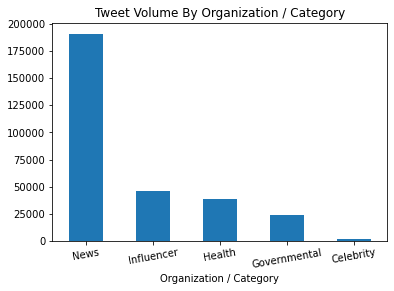

In [98]:
p_tweet_vol_df3_org.plot(kind = 'bar', x = 'Organization / Category', y = 'Volume', legend = None, \
                        title = 'Tweet Volume By Organization / Category')
plt.xticks(rotation = 10)
pass

### 2. Retweet Count

In [27]:
retweet_count_df3 = df3_original.groupBy('id').agg(sum('retweet_quote'))

In [28]:
retweet_count_df3

id,sum(retweet_quote)
1000965128928440321,0
100136328,0
1002158734121095168,0
1002294977731416064,0
100301510,0
100331607,0
1003744880001277953,0
100390036,0
1003989100767141889,0
1004072414903447552,0


In [31]:
retweet_count_df3.orderBy('sum(retweet_quote)', ascending = False)

id,sum(retweet_quote)
1000004655433289728,0
1000339176733200384,0
1000446015282040833,0
1000804706086727680,0
1000939408143585280,0
1001488007126450176,0
100200415,0
1002021766536007687,0
1002251800521641984,0
100251954,0


In [101]:
retweet_count_df3_joined = retweet_count_df3.join(id_username_org_verified, retweet_count_df3.id == id_username_org_verified.id, 'inner')\
                        .drop(id_username_org_verified.id)

In [102]:
retweet_count_df3_joined

sum(retweet_quote),id,username,organization,verified
0,1000965128928440321,TIA,Other,false
0,100136328,Dr. K-Loe Black,Other,false
0,1002158734121095168,Olly⚽️,Other,false
0,1002294977731416064,Yakhunt,Other,false
0,100301510,Jay Edidin,Other,false
0,100331607,La V est belle,Other,false
0,1003485842633969664,Medical Device Pa...,Other,false
0,1003744880001277953,Ginger Swift,Other,false
0,100390036,ARod,Other,false
0,1003989100767141889,Chet Stedman,Other,false


In [103]:
retweet_count_df3_joined = retweet_count_df3_joined.orderBy('sum(retweet_quote)', ascending = False)

In [104]:
retweet_count_df3_joined

sum(retweet_quote),id,username,organization,verified
0,1000128461049073664,Yₒᵤ cₐₙ cₐₗₗ ₘₑ ₖₐᵢ,Other,false
0,1000129804333731840,Missthemse,Other,false
0,1000544863295819777,Boys to men,Other,false
0,1000672732210659328,He's not the mess...,Other,false
0,1000760316806901762,@Babsbeeblue🦊🐝💙🌊,Other,false
0,1000780462237855746,keri,Other,false
0,1000813253029588992,❄️cr0b1n❄️,Other,false
0,1001202797227008000,Paula Blair,Other,false
0,100124807,Lactation Training,Other,false
0,1001374315,crazyeyes10950,Other,false


### 3. Influence Score

In [32]:
df3 = df3.withColumn('influence', (3*df3.retweet_quote + df3.favorite_count2)/df3.volume)

In [34]:
df3 = df3.withColumn('influence', when(df3.retweeted_status.isNotNull(), df3.influence*2).otherwise(df3.influence))

In [37]:
df3_influence = df3.groupBy('id').agg(avg('influence'))

In [39]:
df3_influence

In [40]:
df3_influence_joined = df3_influence.join(id_username_org_verified,df3_influence.id == id_username_org_verified.id, 'inner')\
                        .drop(id_username_org_verified.id)

In [41]:
df3_influence_joined

avg(influence),id,username,organization,verified
1392.0,1000340071180943360,Mahadevan Pattazhy,Other,false
70230.0,1000480061269700608,Gabriel,Other,false
719.8181818181818,1000480351905632258,Marce__Vann__,Other,false
2064.0,1000587623922987009,nat,Other,false
39886.0,1000806617275949058,❀ 𝓩𝓜 ❀,Other,false
43670.0,1000939642546421760,;,Other,false
0.0,1000965128928440321,TIA,Other,false
334221.5,1000966048089165824,sruthidevya,Other,false
8.0,1001118032314425344,Road2IR,Other,false
488.5,1001349037965037570,Alana Alexander,Other,false


In [42]:
df3_influence_joined = df3_influence_joined.orderBy('avg(influence)', ascending = False)

In [43]:
df3_influence_joined

avg(influence),id,username,organization,verified
4723102.0,1419775389308801033,Drake stan account,Other,false
4001136.0,1448860370504986661,WambuiNjrg,Other,false
4000328.0,1365285562526162948,Saxon,Other,false
3998720.0,2342460706,b,Other,false
3995884.0,1191438743426797569,huberb,Other,false
3994816.0,756436340221284354,karmaisabitch,Other,false
3993752.0,1335570482242805761,BHR,Other,false
3992450.0,1450105718875459590,Jamet,Other,false
3532514.0,1449009263028940801,Georgia Zeagler,Other,false
3532150.0,1449070331495387145,Delphia Sammis,Other,false


In [44]:
p_df3_influence_joined = df3_influence_joined.toPandas()

In [46]:
p_df3_influence_joined = p_df3_influence_joined.rename(columns = {'avg(influence)': 'Influence Score', 'username': 'Username', \
                                                                 'organization': 'Organization', 'verified': 'Verified'})

In [47]:
p_df3_influence_joined[['Username', 'Organization', 'Verified']].iloc[:10, :]

,Username,Organization,Verified
0,Drake stan account,Other,False
1,WambuiNjrg,Other,False
2,Saxon,Other,False
3,b,Other,False
4,huberb,Other,False
5,karmaisabitch,Other,False
6,BHR,Other,False
7,Jamet,Other,False
8,Georgia Zeagler,Other,False
9,Delphia Sammis,Other,False


In [52]:
df3_influence_org = df3_influence_joined.filter(df3_influence_joined.organization != 'Other')

In [53]:
df3_influence_org = df3_influence_org.orderBy('avg(influence)', ascending = False)

In [54]:
df3_influence_org

avg(influence),id,username,organization,verified
959182.0,787521481,christopher.🍂,News,true
946156.0,630191758,Alicia Atout,News,true
930688.0,305831124,George Richert,News,true
927372.0,99396746,Stephanie Ochoa,News,true
894712.0,19973100,"Susan Newman, Ph.D.",News,true
881132.0,109143439,Suzy Nakamura ✶ ✶...,Influencer,true
879136.0,93270398,Susan Kelechi Watson,Influencer,true
877322.0,18890465,James Silva,Influencer,true
860886.0,24268066,Brad Friedman,News,true
856776.0,2155248452,Adam Hattersley,Governmental,true


In [ ]:
df3_influence_org_100 = df3_influence_org.head(100)

In [56]:
p_df3_influence_org = df3_influence_org.toPandas()

In [66]:
p_df3_influence_org_100 = p_df3_influence_org.iloc[:100, :]

In [67]:
spark.conf.set("spark.sql.execution.arrow.enabled","true")
top_100_df=spark.createDataFrame(p_df3_influence_org_100) 

In [69]:
top_100_df_infl = top_100_df.groupBy('Organization').count()

In [70]:
top_100_df_infl

Organization,count
Influencer,35
Health,1
Governmental,13
Celebrity,3
News,48


In [71]:
top_100_df_infl = top_100_df_infl.orderBy('count', ascending = False)

In [73]:
p_top_100_df_infl = top_100_df_infl.toPandas()

In [74]:
p_top_100_df_infl

,Organization,count
0,News,48
1,Influencer,35
2,Governmental,13
3,Celebrity,3
4,Health,1


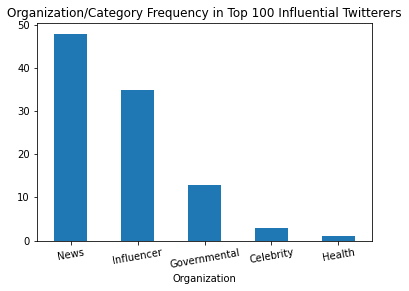

In [78]:
p_top_100_df_infl.plot(kind = 'bar', x = 'Organization', y = 'count', legend = None, \
                       title = 'Organization/Category Frequency in Top 100 Influential Twitterers')
plt.xticks(rotation = 10)
pass

In [96]:
user_org_dist = df3.select('id', 'organization').distinct()

In [30]:
# Number of twitterers by organization
user_org_dist.groupBy('organization').count()

organization,count
Influencer,16314
Health,4697
Other,3319676
Governmental,6934
Celebrity,577
News,25025


#### Additional EDA

##### Number of users

In [31]:
df3.select('id').distinct().count()

3372761

##### Number of users by country

In [35]:
user_loc_dist = df3.select('id', 'location3').distinct()

In [41]:
user_loc_dist

id,location3
1038754863268675584,US
1142866230208073741,US
115780254,🇳🇱
1303752792239030272,"भुवनेश्वर, भारत"
1329172490023817223,US
1353491674467590144,US
1389323909774733316,night changes
1389323909774733316,she/her
1411105530,US
1435400654936281096,US


In [42]:
user_loc_temp_ord = user_loc_dist.groupBy('location3').count()

In [43]:
t = user_loc_temp_ord.orderBy('count', ascending = False)

In [44]:
p_t = t.toPandas()

In [45]:
p_t

,location3,count
0,US,1598516
1,None,1219415
2,UK,225256
3,Africa,8593
4,she/her,7782
...,...,...
149785,Roseburg Oregon,1
149786,eggs,1
149787,Fier,1
149788,"Keep your head up, love",1


In [48]:
p_t2 = p_t.drop([1])

In [49]:
p_t2

,location3,count
0,US,1598516
2,UK,225256
3,Africa,8593
4,she/her,7782
5,Europe,7589
...,...,...
149785,Roseburg Oregon,1
149786,eggs,1
149787,Fier,1
149788,"Keep your head up, love",1


In [50]:
tot = p_t2['count'].sum()

In [51]:
p_t2 = p_t2.iloc[:100, :]

In [1]:
p_t2['percentage'] = p_t2['count']/tot

In [53]:
p_t3 = p_t2.drop([4, 9, 10, 12, 13, 14, 15, 16, 17, 18, 19])

In [54]:
p_t3

,location3,count,percentage
0,US,1598516,0.737074
2,UK,225256,0.103865
3,Africa,8593,0.003962
5,Europe,7589,0.003499
6,Canada,5379,0.002480
...,...,...,...
96,Brunei,224,0.000103
97,Unknown,224,0.000103
98,Durban,222,0.000102
99,Tanzania,222,0.000102


In [55]:
tot2 = p_t3['count'].sum()

In [56]:
p_t3['percentage'] = p_t3['count']/tot2

In [57]:
p_t3.iloc[:10, :]

,location3,count,percentage
0,US,1598516,0.847894
2,UK,225256,0.119482
3,Africa,8593,0.004558
5,Europe,7589,0.004025
6,Canada,5379,0.002853
7,Australia,5176,0.002745
8,India,4728,0.002508
11,Hong Kong,1288,0.000683
20,Oregon,733,0.000389
21,,733,0.000389


In [58]:
p_t4 = p_t3.iloc[0:8, :]

In [59]:
p_t4

,location3,count,percentage
0,US,1598516,0.847894
2,UK,225256,0.119482
3,Africa,8593,0.004558
5,Europe,7589,0.004025
6,Canada,5379,0.002853
7,Australia,5176,0.002745
8,India,4728,0.002508
11,Hong Kong,1288,0.000683


In [2]:
p_t4['Percentage'] = p_t4['percentage']*100

In [65]:
p_t5 = p_t4.round(2)

In [83]:
p_t5 = p_t5.rename(columns = {'location3': 'Location'})

In [84]:
p_t5.drop(['count', 'percentage'], axis = 1)

,Location,Percentage
0,US,84.79
2,UK,11.95
3,Africa,0.46
5,Europe,0.40
6,Canada,0.29
7,Australia,0.27
8,India,0.25
11,Hong Kong,0.07


In [71]:
import matplotlib.pyplot as plt

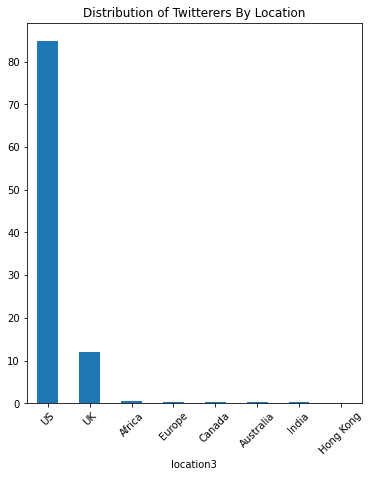

In [77]:
p_t5.plot(kind = 'bar', x = 'location3', y = 'Percentage', title = 'Distribution of Twitterers By Location', legend = None, \
         figsize = (6,7))
plt.xticks(rotation = 45)
pass

### Additional Retweet Analysis

In [126]:
user_retweet = df3.select('id', 'retweeted_status').distinct()

In [128]:
#user_retweet

In [130]:
user_retweet = user_retweet.withColumn('original', user_retweet.retweeted_status.isNull())

In [131]:
user_retweet

id,retweeted_status,original
1007838595,"[,, Sat Oct 23 05...",false
101168641,"[,, Fri Oct 22 11...",false
1013959118258925568,"[,, Mon Nov 01 09...",false
1019150012654276609,"[,, Tue Nov 02 19...",false
1019722008,"[,, Mon Nov 08 08...",false
1036636467165057026,"[,, Tue Oct 19 21...",false
1051706699596234752,"[,, Sun Oct 17 23...",false
105942601,"[,, Wed Oct 20 15...",false
1061420826,"[,, Sun Oct 17 23...",false
1069672669,"[,, Mon Oct 25 21...",false


In [132]:
influence_df2_org_ord = influence_df2_org_ord.join(user_retweet, influence_df2_org_ord.id == user_retweet.id).drop(user_retweet.id)

In [133]:
influence_df2_org_ord

avg(influence_score),id,organization,username,retweeted_status,original
0.0,10162772,News,Tabetha Wallace,null,true
14.714285714285712,102304622,News,Mustafa Plumber,"[,, Thu Oct 21 13...",false
14.714285714285712,102304622,News,Mustafa Plumber,"[,, Mon Oct 25 13...",false
14.714285714285712,102304622,News,Mustafa Plumber,"[,, Wed Nov 03 03...",false
14.714285714285712,102304622,News,Mustafa Plumber,"[,, Sun Oct 17 19...",false
14.714285714285712,102304622,News,Mustafa Plumber,null,true
0.0,1029047922,News,Susan Bagwell - I...,null,true
0.0,103023317,Health,Medscape Surgery,null,true
3318.0,10342612,News,Jack 🍄🪰 Scanlan,"[,, Tue Nov 09 23...",false
2.285714285714285,1035358050230521856,News,VICE Asia,"[,, Tue Nov 09 10...",false


In [3]:
p_influence_df2_org_ord = influence_df2_org_ord.toPandas()

In [135]:
p_influence_df2_org_ord = p_influence_df2_org_ord.iloc[:100, :]

In [136]:
p_influence_df2_org_ord

,avg(influence_score),id,organization,username,retweeted_status,original
0,0.000000,10162772,News,Tabetha Wallace,None,True
1,14.714286,102304622,News,Mustafa Plumber,"(None, None, Wed Nov 03 03:37:18 +0000 2021, None, ([], None, [], [Row(display_url='livelaw.in/n...",False
2,14.714286,102304622,News,Mustafa Plumber,"(None, None, Sun Oct 17 19:09:53 +0000 2021, None, ([Row(indices=[83, 88], text='POTS')], None, ...",False
3,14.714286,102304622,News,Mustafa Plumber,"(None, None, Thu Oct 21 13:33:20 +0000 2021, None, ([], None, [], [Row(display_url='twitter.com/...",False
4,14.714286,102304622,News,Mustafa Plumber,None,True
...,...,...,...,...,...,...
95,66.500000,14133760,News,Kyle Smith,None,True
96,66.500000,14133760,News,Kyle Smith,"(None, None, Wed Oct 20 17:51:53 +0000 2021, None, ([], None, [], [Row(display_url='twitter.com/...",False
97,9.750000,141341863,Celebrity,John Ibbitson,None,True
98,9.750000,141341863,Celebrity,John Ibbitson,"(None, None, Mon Nov 08 14:02:31 +0000 2021, None, ([], None, [], [Row(display_url='theglobeandm...",False


In [80]:
spark.conf.set("spark.sql.execution.arrow.enabled","true")
top_100_df=spark.createDataFrame(p_influence_df2_org_ord) 

In [81]:
top_100_df.groupBy('organization').count()

organization,count
Influencer,35
Health,2
Governmental,9
Celebrity,3
News,51


#### Tweet Volume

In [31]:
tweet_vol = df3.groupBy('id').agg(avg('volume')).orderBy('avg(volume)', ascending = False)

In [32]:
tweet_vol

id,avg(volume)
3219670842,15349.0
952247125185720320,13668.0
1015456945447170048,6738.0
1032595605737144320,6285.0
1238467680773894146,4998.0
728894570,4888.0
1283765688616628233,4681.0
1269612893529444354,4512.0
1221366000752324609,4076.0
1236273574895329281,3684.0


In [33]:
user_org = df3.select('id', 'organization').distinct()

In [34]:
vol_df1 = tweet_vol.join(user_org, tweet_vol.id == user_org.id, 'left').drop(tweet_vol.id)

In [35]:
vol_df1

avg(volume),id,organization
1.0,1000340071180943360,Other
1.0,1000480061269700608,Other
11.0,1000480351905632258,Other
1.0,1000587623922987009,Other
1.0,1000806617275949058,Other
1.0,1000939642546421760,Other
1.0,1000965128928440321,Other
2.0,1000966048089165824,Other
1.0,1001118032314425344,Other
2.0,1001349037965037570,Other


In [38]:
vol_df2 = vol_df1.join(user_id_name, vol_df1.id == user_id_name.id, 'inner').drop(user_id_name.id)

In [39]:
vol_df2

avg(volume),id,organization,username
1.0,1000340071180943360,Other,Mahadevan Pattazhy
1.0,1000480061269700608,Other,Gabriel
11.0,1000480351905632258,Other,Marce__Vann__
1.0,1000587623922987009,Other,nat
1.0,1000806617275949058,Other,❀ 𝓩𝓜 ❀
1.0,1000939642546421760,Other,;
1.0,1000965128928440321,Other,TIA
2.0,1000966048089165824,Other,sruthidevya
1.0,1001118032314425344,Other,Road2IR
2.0,1001349037965037570,Other,Alana Alexander


In [78]:
vol_df2.orderBy('avg(volume)', ascending = False)

avg(volume),id,organization,username
15349.0,3219670842,Other,Nathan Joyner
13668.0,952247125185720320,Other,#StayHome
6738.0,1015456945447170048,Other,hiremaid.com.sg
6285.0,1032595605737144320,Other,CovidOff Bot 🤖
4998.0,1238467680773894146,Other,Corona Update Bot
4888.0,728894570,Other,iWeller.com
4681.0,1283765688616628233,Other,Galla Go
4512.0,1269612893529444354,Other,News Bht
4076.0,1221366000752324609,Other,World News
3684.0,1236273574895329281,Other,Coronavirus Updates


In [40]:
id_verif = df3.select('id', 'verified').distinct()

In [41]:
vol_df3 = vol_df2.join(id_verif, vol_df2.id == id_verif.id, 'inner').drop(id_verif.id)

In [42]:
vol_temp1 = vol_df3.orderBy('avg(volume)', ascending = False)

In [109]:
vol_temp1

avg(volume),id,organization,username,verified
15349.0,3219670842,Other,Nathan Joyner,false
13668.0,952247125185720320,Other,#StayHome,false
6738.0,1015456945447170048,Other,hiremaid.com.sg,false
6285.0,1032595605737144320,Other,CovidOff Bot 🤖,false
4998.0,1238467680773894146,Other,Corona Update Bot,false
4888.0,728894570,Other,iWeller.com,false
4681.0,1283765688616628233,Other,Galla Go,false
4512.0,1269612893529444354,Other,News Bht,false
4076.0,1221366000752324609,Other,World News,false
3684.0,1236273574895329281,Other,Coronavirus Updates,false


In [43]:
p_vol_temp1 = vol_temp1.toPandas()

In [44]:
p_vol_temp1 = p_vol_temp1.rename(columns = {'avg(volume)': 'Tweet Volume', 'organization': 'Organization', 'verified': 'Verified'})

In [45]:
p_vol_temp1 = p_vol_temp1.drop(['id'], axis = 1)

In [46]:
p_vol_temp1 = p_vol_temp1.rename(columns = {'username': 'Username'})

In [48]:
p_vol_temp1[['Username', 'Verified', 'Organization', 'Tweet Volume']].iloc[:15, :]

,Username,Verified,Organization,Tweet Volume
0,Nathan Joyner,False,Other,15349.0
1,#StayHome,False,Other,13668.0
2,hiremaid.com.sg,False,Other,6738.0
3,CovidOff Bot 🤖,False,Other,6285.0
4,Corona Update Bot,False,Other,4998.0
5,iWeller.com,False,Other,4888.0
6,Galla Go,False,Other,4681.0
7,News Bht,False,Other,4512.0
8,World News,False,Other,4076.0
9,Coronavirus Updates,False,Other,3684.0


In [49]:
p_vol_temp2 = p_vol_temp1.drop([7, 8, 11, 13])

In [51]:
p_vol_temp2[['Username', 'Organization', 'Verified', 'Tweet Volume']].iloc[:10, :]

,Username,Organization,Verified,Tweet Volume
0,Nathan Joyner,Other,False,15349.0
1,#StayHome,Other,False,13668.0
2,hiremaid.com.sg,Other,False,6738.0
3,CovidOff Bot 🤖,Other,False,6285.0
4,Corona Update Bot,Other,False,4998.0
5,iWeller.com,Other,False,4888.0
6,Galla Go,Other,False,4681.0
9,Coronavirus Updates,Other,False,3684.0
10,Jeremy Hume,Other,False,3568.0
12,VonVictor Valentino Rosenchild,Other,False,3104.0


In [79]:
vol_df2_org = vol_df2.filter(vol_df2.organization != 'Other')

In [80]:
vol_df2_org_ord = vol_df2_org.orderBy('avg(volume)', ascending = False)

In [81]:
vol_df2_org_ord

avg(volume),id,organization,username
919.0,1066972567943053312,News,Hindustan Times
867.0,30846824,News,TOI Cities
849.0,15577108,News,Stuff
821.0,1652541,News,Reuters
801.0,15872418,News,ABS-CBN News
647.0,36327407,News,Hindustan Times
624.0,15448383,News,Inquirer
621.0,953924228306305024,Health,Cleavon MD 💉
599.0,54886540,Health,(((Dorit Reiss)))
597.0,48110818,Health,Liz Szabo


In [86]:
p_vol_df2_org_ord = vol_df2_org_ord.toPandas()

In [87]:
p_vol_df2_org_ord = p_vol_df2_org_ord.iloc[:100, :]

In [88]:
spark.conf.set("spark.sql.execution.arrow.enabled","true")
top_100_df=spark.createDataFrame(p_vol_df2_org_ord) 

In [91]:
top_100_df.groupBy('organization').count()

organization,count
Influencer,3
Health,14
Governmental,5
Celebrity,1
News,77


#### Retweet Count

In [95]:
retweet_count = df3.groupBy('id').agg(avg('total_retweet')).orderBy('avg(total_retweet)', ascending = False)

In [96]:
retweet_count

id,avg(total_retweet)
1032595605737144320,3187923.0
2324289248,2208675.0
952247125185720320,1751666.0
1306613556784365571,1034511.0
612931307,981106.0
859780896,905673.0
3278943084,903358.0
2949662215,881843.0
914641134701436929,796891.0
1004873480851148800,772449.0


In [97]:
rt_df1 = retweet_count.join(user_org, retweet_count.id == user_org.id, 'left').drop(retweet_count.id)

In [98]:
rt_df1

avg(total_retweet),id,organization
160.0,1000340071180943360,Other
5853.0,1000480061269700608,Other
7467.0,1000480351905632258,Other
272.0,1000587623922987009,Other
2599.0,1000806617275949058,Other
3667.0,1000939642546421760,Other
0.0,1000965128928440321,Other
72690.0,1000966048089165824,Other
1.0,1001118032314425344,Other
119.0,1001349037965037570,Other


In [99]:
rt_df2 = rt_df1.join(user_id_name, rt_df1.id == user_id_name.id, 'inner').drop(user_id_name.id)

In [100]:
rt_df2

avg(total_retweet),id,organization,username
160.0,1000340071180943360,Other,Mahadevan Pattazhy
5853.0,1000480061269700608,Other,Gabriel
7467.0,1000480351905632258,Other,Marce__Vann__
272.0,1000587623922987009,Other,nat
2599.0,1000806617275949058,Other,❀ 𝓩𝓜 ❀
3667.0,1000939642546421760,Other,;
0.0,1000965128928440321,Other,TIA
72690.0,1000966048089165824,Other,sruthidevya
1.0,1001118032314425344,Other,Road2IR
119.0,1001349037965037570,Other,Alana Alexander


In [103]:
rt_df3 = rt_df2.join(id_verif, rt_df2.id == id_verif.id, 'inner').drop(id_verif.id)

In [124]:
rt_df3 = rt_df3.orderBy('avg(total_retweet)', ascending = False)

In [125]:
p_rt_df3 = rt_df3.toPandas()

In [126]:
p_rt_df3 = p_rt_df3.rename(columns = {'avg(total_retweet)': 'Tweet Retweet', 'organization': 'Organization', 'verified': 'Verified', \
                                     'username': 'Username'})

In [127]:
p_rt_df3 = p_rt_df3.drop(['id'], axis = 1)

In [128]:
p_rt_df3 = p_rt_df3.rename(columns = {'Tweet Retweet': 'Total Rewteet Count'})

In [129]:
p_rt_df3 = p_rt_df3.rename(columns = {'Total Rewteet Count': 'Total Retweet Count'})

In [130]:
p_rt_df3[['Username', 'Organization', 'Verified', 'Total Retweet Count']].iloc[:10, :]

,Username,Organization,Verified,Total Retweet Count
0,CovidOff Bot 🤖,Other,False,3187923.0
1,ContraTerrorismo 🇪🇸,Other,False,2208675.0
2,#StayHome,Other,False,1751666.0
3,...,Other,False,1034511.0
4,A Devoted Yogi,Other,False,981106.0
5,Lesley Gale,Other,False,905673.0
6,Doris Vazquez,Other,False,903358.0
7,"Michael Hung Ming Lin, PhD",Other,False,881843.0
8,Barn owl enthusiast,Other,False,796891.0
9,Juan Roberto Barba Ribera,Other,False,772449.0


In [102]:
rt_df2.orderBy('avg(total_retweet)', ascending = False)

In [104]:
rt_df2_org = rt_df2.filter(rt_df2.organization != 'Other')

In [106]:
rt_df2_org_ord = rt_df2_org.orderBy('avg(total_retweet)', ascending = False)

In [107]:
rt_df2_org_ord

avg(total_retweet),id,organization,username
308328.0,177584156,Influencer,Janie Johnson - A...
171415.0,953924228306305024,Health,Cleavon MD 💉
170257.0,27493883,Influencer,Jon Cooper 🇺🇸
155682.0,757161644090912768,Governmental,Dr. Rajesh Mishra
146705.0,20878297,News,Ezra Levant 🍁
138896.0,174618314,Influencer,Montgomery Granger
124820.0,185174745,Governmental,Martin Cowen
122698.0,40875530,News,"Deb Heine, Dissident"
114692.0,6323932,Health,"Tinu, Empress of ..."
112763.0,91942071,News,🟣 Bobby Umar | K...


In [108]:
p_rt_df2_org_ord = rt_df2_org_ord.toPandas()

In [109]:
p_rt_df2_org_ord = p_rt_df2_org_ord.iloc[:100, :]

In [110]:
spark.conf.set("spark.sql.execution.arrow.enabled","true")
top_100_df=spark.createDataFrame(p_rt_df2_org_ord) 

In [111]:
top_100_df.groupBy('organization').count()

organization,count
Influencer,35
Health,18
Governmental,15
Celebrity,4
News,28


In [ ]:
p_vol_df2_org_ord = vol_df2_org_ord.toPandas()

In [ ]:
p_vol_df2_org_ord = p_vol_df2_org_ord.iloc[:100, :]

In [ ]:
spark.conf.set("spark.sql.execution.arrow.enabled","true")
top_100_df=spark.createDataFrame(p_influence_df2_org_ord) 

In [ ]:
top_100_df.groupBy('organization').count()

### Total Users By Country

In [47]:
# df2 = df2.withColumn('location3', 
#                     F.when(df2.location2.contains('US'), 'US').otherwise(df2.location2))

In [67]:
from pyspark.sql.functions import countDistinct

In [76]:
user_loc_df = df3.select('id', 'location3')

In [80]:
user_loc_df1 = df3.groupBy('location3').count()

In [81]:
user_loc_df1

location3,count
🌌,189
zzzzzzzzz,1
Utah,2424
The ghetto,4
🇧🇸,27
dunkrry,1
Heaven,959
Cromvoirt (Vught),2
"Louisville, Louis...",33
"St George, UT",168


In [84]:
user_loc_df1 = user_loc_df1.orderBy('count', ascending = False)

In [85]:
user_loc_df1

location3,count
US,7801074
null,6363828
UK,1421962
Europe,48993
Canada,30276
Australia,27208
Africa,23689
India,16910
കേരളം,13696
she/her,12125


In [73]:
#user_loc_df = df3.groupBy('location3').agg(countDistinct('id')).orderBy('count(id)', ascending = False)

In [88]:
p_user_loc = user_loc_df1.limit(14).toPandas()

In [89]:
p_user_loc 

,location3,count
0,US,7801074
1,None,6363828
2,UK,1421962
3,Europe,48993
4,Canada,30276
5,Australia,27208
6,Africa,23689
7,India,16910
8,കേരളം,13696
9,she/her,12125


In [90]:
p_user_loc = p_user_loc.drop([1, 3, 8, 9, 10, 11, 13])

In [91]:
p_user_loc

,location3,count
0,US,7801074
2,UK,1421962
4,Canada,30276
5,Australia,27208
6,Africa,23689
7,India,16910
12,World,5839


In [93]:
p_user_loc = p_user_loc.rename(columns={"location3": "Country", "count": "Number of Users"}) 

In [84]:
p_user_loc_percent = p_user_loc

In [95]:
p_user_loc

,Country,Number of Users
0,US,7801074
2,UK,1421962
4,Canada,30276
5,Australia,27208
6,Africa,23689
7,India,16910
12,World,5839


In [96]:
#ot = p_user_loc_percent[:,2].sum()
p_user_loc['Number of Users'] = p_user_loc['Number of Users'] / p_user_loc['Number of Users'].sum()

In [97]:
p_user_loc

,Country,Number of Users
0,US,0.836401
2,UK,0.152457
4,Canada,0.003246
5,Australia,0.002917
6,Africa,0.002540
7,India,0.001813
12,World,0.000626


In [98]:
data = [['The US', '83.64%'], ['The UK', '15.25%'], ['Canada', '0.32%'], ['Australia', '0.29%'], ['India', '0.18%'], \
       ['Other', '0.32%']]
  
# Create the pandas DataFrame
df = pd.DataFrame(data, columns = ['Country', 'Percentage'])

In [99]:
df

,Country,Percentage
0,The US,83.64%
1,The UK,15.25%
2,Canada,0.32%
3,Australia,0.29%
4,India,0.18%
5,Other,0.32%


#### Influential Twitterers

In [34]:
retweets_df = df2.groupBy('username').agg(sum('retweet_quote'))

In [33]:
retweets_ordered_df = df2.groupBy('username').agg(sum('retweet_quote')).orderBy('sum(retweet_quote)', ascending = False)

In [34]:
display(retweets_ordered_df)

username,sum(retweet_quote)
.,24931423
ً,11291134
J,8009145
David,7631572
Chris,7321221
John,6926391
Mike,6753510
Alex,6616218
Michael,6178813
🦋,6011981


#### Tweets/Retweets By Organization

In [59]:
tweets_vol_org = df3.groupBy('organization').agg(count('text')).orderBy('count(text)', ascending = False)

In [60]:
tweets_vol_org

organization,count(text)
Other,16400461
News,255388
Influencer,81391
Health,64192
Governmental,43246
Celebrity,3198


In [83]:
#df3

In [86]:
retweets_count_org = df3.groupBy('organization').agg(sum('retweet_quote')).orderBy('sum(retweet_quote)', ascending = False)

In [87]:
retweets_count_org

organization,sum(retweet_quote)
Other,16512817730
News,17570279
Influencer,15456638
Health,5940796
Governmental,5862971
Celebrity,1268410


In [61]:
p_tweets_vol_org = tweets_vol_org.toPandas()

In [88]:
p_retweet_count_org = retweets_count_org.toPandas()

In [49]:
p_tweets_vol_org = p_tweets_vol_org.reindex([5, 3, 1, 4, 0, 2])

In [51]:
p_retweets_count_org = p_retweet_count_org.reindex([5, 3, 1, 4, 0, 2])

In [62]:
p_tweets_vol_org

,organization,count(text)
0,Other,16400461
1,News,255388
2,Influencer,81391
3,Health,64192
4,Governmental,43246
5,Celebrity,3198


In [63]:
p_tweets_vol_org1 = p_tweets_vol_org.drop([0])

In [64]:
p_tweets_vol_org1

,organization,count(text)
1,News,255388
2,Influencer,81391
3,Health,64192
4,Governmental,43246
5,Celebrity,3198


In [71]:
import matplotlib.pyplot as plt

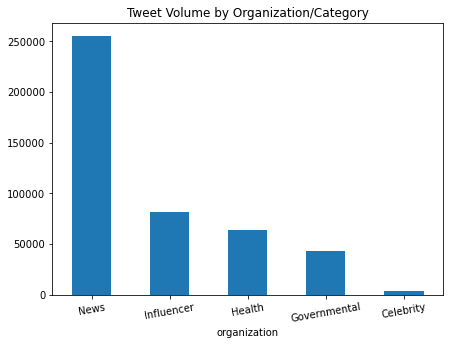

In [79]:
p_tweets_vol_org1.plot(kind = 'bar', x = 'organization', y = 'count(text)', figsize = (7,5), \
                      title = 'Tweet Volume by Organization/Category',  legend = None)
plt.xticks(rotation = 10)
pass

In [90]:
p_retweet_count_org

,organization,sum(retweet_quote)
0,Other,16512817730
1,News,17570279
2,Influencer,15456638
3,Health,5940796
4,Governmental,5862971
5,Celebrity,1268410


In [91]:
p_retweet_count_org1 = p_retweet_count_org.drop([0])

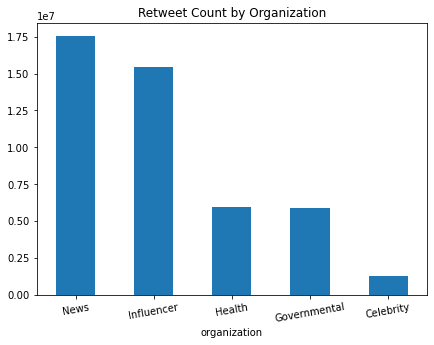

In [94]:
p_retweet_count_org1.plot(kind = 'bar', x = 'organization', y = 'sum(retweet_quote)', figsize = (7,5), \
                      title = 'Retweet Count by Organization', legend = None)
plt.xticks(rotation = 10)
pass

In [91]:
vol = p_tweets_vol_org1['count(text)'].tolist()

In [92]:
retweet = p_retweet_count_org1['sum(retweet_quote)'].tolist()

In [95]:
index = ['News', 'Governmental', 'Healthcare', 'Celebrity', 'Influencer']

In [96]:
df_temp = pd.DataFrame({'Tweet Volume': vol, 'Retweet Count': retweet}, index = index)

In [97]:
df_temp

,Tweet Volume,Retweet Count
News,253631,14380679
Governmental,36032,4496205
Healthcare,52788,4616409
Celebrity,56171,10070060
Influencer,61912,16438959


In [64]:
# from sklearn.preprocessing import StandardScaler
# std_scaler = StandardScaler()
# df_temp[['Tweet Volume', 'Retweet Count']] = std_scaler.fit_transform(df_temp[['Tweet Volume', 'Retweet Count']])

In [68]:
df_temp['Tweet Volume'] = df_temp['Tweet Volume'] / df_temp['Tweet Volume'].sum()

In [70]:
df_temp['Retweet Count'] = df_temp['Retweet Count'] / df_temp['Retweet Count'].sum()

In [72]:
df_temp

,Tweet Volume,Retweet Count
News,0.015054,0.000868
Governmental,0.002139,0.000272
Healthcare,0.003133,0.996980
Celebrity,0.003334,0.000279
Influencer,0.003675,0.000608
Other,0.972665,0.000993


In [36]:
retweets_ordered_df2 = df2.groupBy('username').agg(sum('retweet_count2')).orderBy('sum(retweet_count2)', ascending = False)

In [37]:
display(retweets_ordered_df2)

username,sum(retweet_count2)
.,22831011
ً,10378146
J,7280810
David,6859580
Chris,6487281
John,6231946
Mike,6063668
Alex,5946921
🦋,5500833
Michael,5462263


In [42]:
display(retweets_df)

username,sum(retweet_quote)
Ali Sargent,1929
Anna May,10881
AUG EII,3
Mary Lucas,66734
Isabel Horvath,64108
Deb Weston,10307
hana torat,0
Love Our Presiden...,161127
𝗠𝗮𝗿𝘆𝗕𝗲𝘁𝗵?...,129946
El Presidente SM,14520


In [43]:
tweets_df = df2.groupBy('username').agg(count('text'))

In [44]:
display(tweets_df)

username,count(text)
Tyler,824
Denny Active,1
K,2897
Gives 0 Show (POD...,8
Sislybear,2
c.,60
Dr Neil Pender BM...,4
ن Rose,18
Rain Parker,29
spencer walker,231


In [45]:
influential_df = retweets_df.alias('r').join(tweets_df.alias('t'), tweets_df.username ==  tweets_df.username, "inner").\
                                             select('r.username', 'r.sum(retweet_quote)', 't.count(text)')

In [46]:
display(influential_df)

username,sum(retweet_quote),count(text)
"""Jump-Scare"" Josh B.",0,1
"""Muppet"" is not a...",417,4
#1 Mood Ring fan,11659,1
#1 kr beast fan,3740,4
#1 stupid bitch,4,1
#24 💫,81,2
#271 - Lizzy Dayt...,1,1
#45 Affect,611,5
#4EvaNook 🕊,1,1
#AbafanaAbafani,0,3


In [47]:
influential_df = influential_df.withColumn('tweet_ratio', \
                                           influential_df['sum(retweet_quote)'] / influential_df['count(text)'])

In [48]:
#display(influential_df)

In [49]:
top_10_percent = influential_df.orderBy('tweet_ratio', ascending = False)

In [50]:
display(top_10_percent)

username,sum(retweet_quote),count(text),tweet_ratio
Drake stan account,372000,1,372000.0
WambuiNjrg,277537,1,277537.0
huberb,277148,1,277148.0
Jamet,277108,1,277108.0
karmaisabitch,277062,1,277062.0
putra Lampung,221367,1,221367.0
bae couleè,212408,1,212408.0
greg :D,193418,1,193418.0
cathyy,381062,2,190531.0
Kamogelo A. Mokoape,371796,2,185898.0


In [52]:
top_10_percent = top_10_percent.toPandas()

In [53]:
top_10_temp = top_10_percent.iloc[:287241, :]

In [176]:
display(top_10_temp)

,username,sum(retweet_count2),count(text),tweet_ratio
0,Drake stan account,362880,1,362880.000000
1,WambuiNjrg,228965,1,228965.000000
2,huberb,228575,1,228575.000000
3,Jamet,228535,1,228535.000000
4,karmaisabitch,228489,1,228489.000000
...,...,...,...,...
287236,Carmondai76 falscher Ort falsche Zeit,10112,3,3370.666667
287237,MARION ANN CAMERON❤️💋,60671,18,3370.611111
287238,KarenTined,16853,5,3370.600000
287239,我軀鎭四加愚羅不炎,6741,2,3370.500000


In [49]:
spark.conf.set("spark.sql.execution.arrow.enabled","true")
top_10_df=spark.createDataFrame(top_10_temp) 

In [50]:
influential_twitterers = top_10_df.join(df2, top_10_df.username == df2.username, "left")

# influential_df = retweets_df.alias('r').join(tweets_df.alias('t'), tweets_df.username ==  tweets_df.username, "inner").\
#                                              select('r.username', 'r.sum(retweet_count2)', 't.count(text)')

In [113]:
display(influential_twitterers)

username,sum(retweet_count2),count(text),tweet_ratio,created_at,id_str,text,entities,user,retweeted_status,retweet_count,favorite_count,quote_count,lang,name,location,favorites_count2,followers_count2,statuses_count2,coord,retweet_count2,verified,screen_name,username,description,description2,organization
#1 Mood Ring fan,11541,1,11541.0,Sat Oct 30 09:39:...,1454382448905793539,RT @TreJames_: If...,"[[],, [], [], [[4...","[false, Wed Nov 2...","[,, Thu Oct 28 22...",0,0,0,en,micheIIemybelle,she/they,54998,864,69253,null,11541,false,micheIIemybelle,#1 Mood Ring fan,Spider-Man: Into ...,spider-man: into ...,Other
#LLJM,57958,1,57958.0,Thu Nov 04 01:09:...,1456066015704465408,RT @itslinzzzz: I...,"[[],, [], [], [[1...","[false, Mon Jan 1...","[,, Tue Nov 02 19...",0,0,0,en,amourbriii_,null,109389,438,32847,null,57958,false,amourbriii_,#LLJM,IG| @ _itss.brii_,ig| @ _itss.brii_,Other
#_#,7854,1,7854.0,Wed Oct 27 20:24:...,1453457539664732165,RT @ChristianWaec...,"[[],, [], [], [[1...","[false, Thu Nov 0...","[,, Wed Oct 27 06...",0,0,0,en,hermioneanj,null,12229,301,5351,null,7854,false,hermioneanj,#_#,tanak kenal,tanak kenal,Other
$agiterrorist,49428,1,49428.0,Wed Nov 03 20:15:...,1455991933894070275,RT @itslinzzzz: I...,"[[],, [], [], [[1...","[false, Thu Jun 1...","[,, Tue Nov 02 19...",0,0,0,en,kb122_,null,44761,187,11542,null,49428,false,kb122_,$agiterrorist,ig: @younggkb1 a ...,ig: @younggkb1 a ...,Other
$ailar Ocean 🎃,25648,1,25648.0,Mon Oct 25 02:41:...,1452465221126197248,RT @abcdrih: amer...,"[[],, [], [], [[4...","[false, Tue Jun 0...","[,, Sat Oct 23 17...",0,0,0,en,clownsiedad,Venecoland,4390,508,16914,null,25648,false,clownsiedad,$ailar Ocean 🎃,29a♊ | Compro Pay...,29a♊ | compro pay...,Other
$lim.🤪🥰,13066,1,13066.0,Mon Oct 25 05:57:...,1452514672679264259,RT @Sasyity: Imag...,"[[],, [], [], [[1...","[false, Fri Apr 1...","[,, Sun Oct 24 18...",0,0,0,en,nuasgokrazy,Bitch I Dont Fuck...,5744,128,16407,null,13066,false,nuasgokrazy,$lim.🤪🥰,You’ll love me.,you’ll love me.,Other
$pooky $ensei 🏴‍☠️,48896,5,9779.2,Mon Oct 25 15:39:...,1452661005356568585,RT @ElyKreimendah...,"[[],, [], [], [[1...","[false, Tue Nov 2...","[,, Sun Oct 24 20...",0,0,0,en,SkeletonSensei,Planet Zebes,129086,890,218651,null,4480,false,SkeletonSensei,$pooky $ensei 🏴‍☠️,he sensed a trick...,he sensed a trick...,Other
$pooky $ensei 🏴‍☠️,48896,5,9779.2,Wed Nov 03 01:42:...,1455711983836311553,RT @itslinzzzz: I...,"[[],, [], [], [[1...","[false, Tue Nov 2...","[,, Tue Nov 02 19...",0,0,0,en,SkeletonSensei,Planet Zebes,129320,889,219077,null,8908,false,SkeletonSensei,$pooky $ensei 🏴‍☠️,he sensed a trick...,he sensed a trick...,Other
$pooky $ensei 🏴‍☠️,48896,5,9779.2,Fri Oct 29 23:40:...,1454231716999139328,RT @laurenchloeee...,"[[],, [], [], [[1...","[false, Tue Nov 2...","[,, Thu Oct 28 08...",0,0,0,en,SkeletonSensei,Planet Zebes,129216,889,218908,null,13373,false,SkeletonSensei,$pooky $ensei 🏴‍☠️,he sensed a trick...,he sensed a trick...,Other
$pooky $ensei 🏴‍☠️,48896,5,9779.2,Sat Oct 16 02:50:...,1449206113426153472,RT @julianlewis20...,"[[],, [], [], [[7...","[false, Tue Nov 2...","[,, Fri Oct 15 17...",0,0,0,en,SkeletonSensei,Planet Zebes,128783,891,218084,null,187,false,SkeletonSensei,$pooky $ensei 🏴‍☠️,he sensed a trick...,he sensed a trick...,Other


## Date Analysis

In [100]:
oct_df = df3.filter(df3.date < '2021-11-01')

In [104]:
#oct_df

In [143]:
oct_df.count()

10160309

In [101]:
nov_df = df3.filter(df3.date >= '2021-11-01')

In [95]:
#nov_df

In [144]:
nov_df.count()

6687567

In [102]:
oct_df_loc = oct_df.groupBy('location3').agg(count('text')).orderBy('count(text)', ascending = False)

In [103]:
oct_df_loc

location3,count(text)
US,4649802
null,3821830
UK,923290
Europe,32183
Canada,18382
Australia,18205
Africa,15340
India,11129
she/her,7053
കേരളം,6409


In [104]:
p_oct_df_loc = oct_df_loc.limit(40).toPandas()

In [105]:
p_oct_df_loc  

,location3,count(text)
0,US,4649802
1,None,3821830
2,UK,923290
3,Europe,32183
4,Canada,18382
5,Australia,18205
6,Africa,15340
7,India,11129
8,she/her,7053
9,കേരളം,6409


In [106]:
p_oct_df_loc = p_oct_df_loc.drop([1])

In [107]:
p_oct_df_loc

,location3,count(text)
0,US,4649802
2,UK,923290
3,Europe,32183
4,Canada,18382
5,Australia,18205
6,Africa,15340
7,India,11129
8,she/her,7053
9,കേരളം,6409
10,Everywhere,5462


In [125]:
p_oct_df_loc = p_oct_df_loc.iloc[0:7, ]

In [128]:
p_oct_df_loc = p_oct_df_loc.drop([6])

In [112]:
p_oct_df_loc = p_oct_df_loc.drop([3])

In [121]:
#(df-df.min())/(df.max()-df.min())



p_oct_df_loc['scaled_count'] = (p_oct_df_loc['count(text)'] - p_oct_df_loc[['count(text)']].min())/(p_oct_df_loc['count(text)'].max() - p_oct_df_loc['count(text)'].min())







<ipython-input-121-e04357c2c440>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  p_oct_df_loc['scaled_count'] = (p_oct_df_loc['count(text)'] - p_oct_df_loc[['count(text)']].min())/(p_oct_df_loc['count(text)'].max() - p_oct_df_loc['count(text)'].min())


In [129]:
p_oct_df_loc1 = p_oct_df_loc.iloc[0:5, ]

In [130]:
p_oct_df_loc1

,location3,count(text)
0,US,4649802
2,UK,923290
4,Canada,18382
5,Australia,18205
7,India,11129


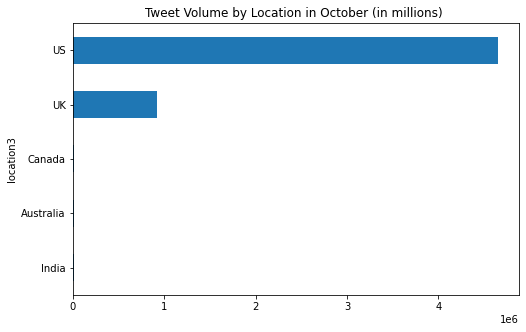

In [131]:
p_oct_df_loc1.plot(kind = 'barh', x = 'location3', y = 'count(text)', title = 'Tweet Volume by Location in October (in millions) ',\
                  legend = None,\
                figsize = (8, 5)).invert_yaxis()

In [117]:
nov_df_loc = nov_df.groupBy('location3').agg(count('text')).orderBy('count(text)', ascending = False)

In [136]:
p_nov_df_loc = nov_df_loc.limit(40).toPandas()

In [137]:
p_nov_df_loc  

,location3,count(text)
0,US,3151272
1,None,2541998
2,UK,498672
3,Europe,16810
4,Canada,11894
5,Australia,9003
6,Africa,8349
7,കേരളം,7287
8,India,5781
9,she/her,5072


In [138]:
p_nov_df_loc = p_nov_df_loc.drop([1, 3, 6, 7])

In [139]:
p_nov_df_loc

,location3,count(text)
0,US,3151272
2,UK,498672
4,Canada,11894
5,Australia,9003
8,India,5781
9,she/her,5072
10,Everywhere,4198
11,Hong Kong,2729
12,World,2305
13,Oregon,2246


In [140]:
p_nov_df_loc = p_nov_df_loc.iloc[0:5,]

In [141]:
p_nov_df_loc

,location3,count(text)
0,US,3151272
2,UK,498672
4,Canada,11894
5,Australia,9003
8,India,5781


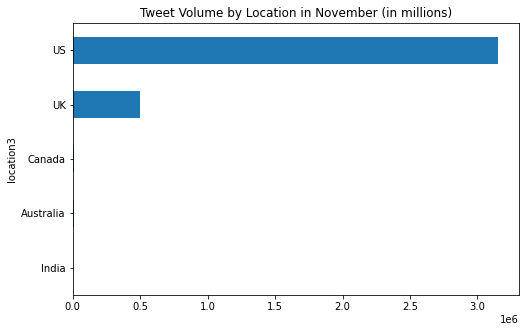

In [142]:
p_nov_df_loc.plot(kind = 'barh', x = 'location3', y = 'count(text)',\
                  title = 'Tweet Volume by Location in November (in millions)', legend = None,\
                 figsize = (8, 5)).invert_yaxis()

### Date Analysis by Organization/Category

In [ ]:
news_df = df2.filter(df2.organization == 'News')

In [ ]:
news_df_date = news_df.groupBy('date').agg(count('text')).orderBy('date', ascending = True)

In [ ]:
p_news_df_date = news_df_date.toPandas()

In [ ]:
news = p_news_df_date['count(text)'].tolist()

In [ ]:
# Governmental

gov_df = df2.filter(df2.organization == 'Governmental')

In [ ]:
gov_df_date = gov_df.groupBy('date').agg(count('text')).orderBy('date', ascending = True)

In [48]:
p_gov_df_date = gov_df_date.toPandas()

In [49]:
gov = p_gov_df_date['count(text)'].tolist()

In [50]:
# Healthcare 

health_df = df2.filter(df2.organization == 'Health')

In [51]:
health_df_date = health_df.groupBy('date').agg(count('text')).orderBy('date', ascending = True)

In [52]:
p_health_df_date = health_df_date.toPandas()

In [53]:
health = p_health_df_date['count(text)'].tolist()

In [54]:
# Celebrity 

celeb_df = df2.filter(df2.organization == 'Celebrity')

In [55]:
celeb_df_date = celeb_df.groupBy('date').agg(count('text')).orderBy('date', ascending = True)

In [56]:
p_celeb_df_date = celeb_df_date.toPandas()

In [57]:
celeb = p_celeb_df_date['count(text)'].tolist()

In [59]:
# Influencer 

infl_df = df2.filter(df2.organization == 'Influencer')

In [60]:
infl_df_date = infl_df.groupBy('date').agg(count('text')).orderBy('date', ascending = True)

In [61]:
p_infl_df_date = infl_df_date.toPandas()

In [62]:
infl = p_infl_df_date['count(text)'].tolist()

In [63]:
# Influencer 

other_df = df2.filter(df2.organization == 'Other')

In [64]:
other_df_date = other_df.groupBy('date').agg(count('text')).orderBy('date', ascending = True)

In [65]:
p_other_df_date = other_df_date.toPandas()

In [66]:
other = p_other_df_date['count(text)'].tolist()

In [67]:
# Date

date = p_other_df_date['date'].tolist()

In [69]:
#import matplotlib.pyplot as plt

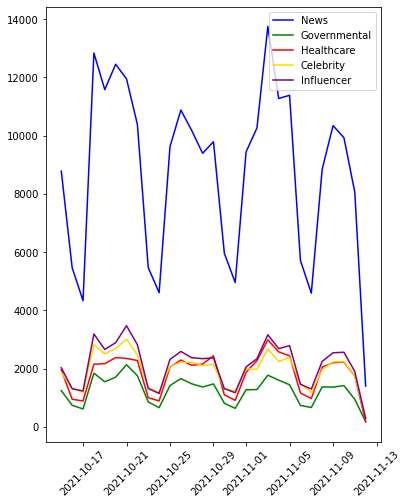

In [89]:
# Plot a simple line chart
plt.rcParams["figure.figsize"] = (6,8)
plt.plot(date, news, 'b', label='News')
plt.plot(date, gov, 'g', label='Governmental')
plt.plot(date, health, 'r', label='Healthcare')
plt.plot(date, celeb, 'gold', label='Celebrity')
plt.plot(date, infl, 'purple', label='Influencer')

plt.xticks(rotation=45)
plt.legend()
# plt.show()

### Original Content Analysis

In [34]:
original_df = df2.filter(df2.retweeted_status.isNull())

In [35]:
original_df_org = original_df.groupBy('organization').agg(count('text')).orderBy('count(text)', ascending = False)

In [36]:
p_original_df_org = original_df_org.toPandas()

In [37]:
p_original_df_org

,organization,count(text)
0,Other,4492806
1,News,190704
2,Celebrity,33394
3,Health,32191
4,Influencer,30251
5,Governmental,20208


In [38]:
retweet_df = df2.filter(df2.retweeted_status.isNotNull())

In [39]:
retweet_df_org = retweet_df.groupBy('organization').agg(count('text')).orderBy('count(text)', ascending = False)

In [40]:
p_retweet_df_org = retweet_df_org.toPandas()

In [41]:
p_retweet_df_org

,organization,count(text)
0,Other,11894536
1,News,62927
2,Influencer,31661
3,Celebrity,22777
4,Health,20597
5,Governmental,15824


In [48]:
original = p_original_df_org['count(text)'].tolist()[1:]

In [43]:
p_retweet_df_org.reindex([0,1,3,4,2,5])

,organization,count(text)
0,Other,11894536
1,News,62927
3,Celebrity,22777
4,Health,20597
2,Influencer,31661
5,Governmental,15824


In [49]:
retweet = p_retweet_df_org['count(text)'].tolist()[1:]

In [50]:
index = ['News', 'Celebrity', 'Health', 'Influencer', 'Governmental']

In [51]:
temp = pd.DataFrame({'Original Tweets': original, 'Retweets': retweet}, index=index)

(array([0, 1, 2, 3, 4]),
 [Text(0, 0, 'News'),
  Text(1, 0, 'Celebrity'),
  Text(2, 0, 'Health'),
  Text(3, 0, 'Influencer'),
  Text(4, 0, 'Governmental')])

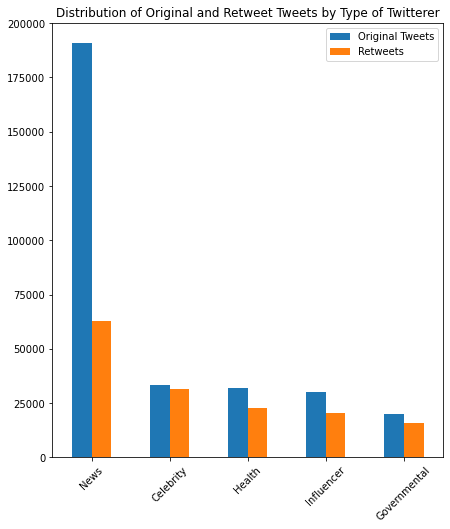

In [59]:
import matplotlib.pyplot as plt
temp.plot.bar(figsize = (7,8), title = 'Distribution of Original and Retweet Tweets by Type of Twitterer')
plt.xticks(rotation=45)

In [60]:
other_original = p_original_df_org['count(text)'].tolist()[0]

In [61]:
other_retweet = p_retweet_df_org['count(text)'].tolist()[0]

In [62]:
index = ['Other']

In [63]:
temp = pd.DataFrame({'Original Tweets': other_original, 'Retweets': other_retweet}, index=index)

(array([0]), [Text(0, 0, 'Other')])

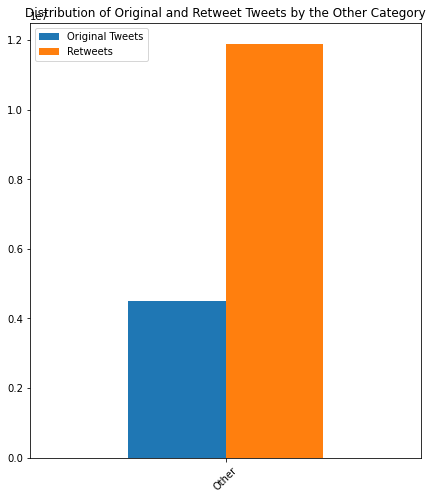

In [64]:
#import matplotlib.pyplot as plt
temp.plot.bar(figsize = (7,8), title = 'Distribution of Original and Retweet Tweets by the Other Category')
plt.xticks(rotation=45)

#### Influence By Organization

In [132]:
influential_org = influential_tweeterers.groupBy('organization').agg(count('text')).orderBy('count(text)', ascending = False)

In [133]:
influential_org.show()

+------------+-----------+
|organization|count(text)|
+------------+-----------+
|       Other|     594185|
|        News|        540|
|  Influencer|        494|
|   Celebrity|        276|
|Governmental|        109|
|      Health|         59|
+------------+-----------+



In [134]:
p_influential_org = influential_org.toPandas()

In [135]:
p_influential_org = p_influential_org.iloc[1:, :]

In [136]:
tot = p_influential_org['count(text)'].sum()

In [137]:
p_influential_org['percentage'] = p_influential_org['count(text)']/tot

<AxesSubplot:title={'center':'Influential Tweeterers By Type'}, xlabel='organization'>

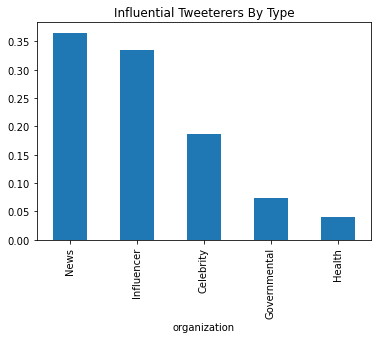

In [138]:
p_influential_org.plot(kind = 'bar', x = 'organization', y = 'percentage', \
                     title = 'Influential Tweeterers By Type', legend = None)

#### Date of Influential Tweets

In [139]:
influential_date = influential_tweeterers.groupBy('date').agg(count('text')).orderBy('date', ascending = True)

In [140]:
p_influential_date = influential_date.toPandas()

In [143]:
%matplotlib inline
import pandas as pd
import matplotlib.pyplot as plt

(array([18917., 18921., 18925., 18929., 18932., 18936., 18940., 18944.]),
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

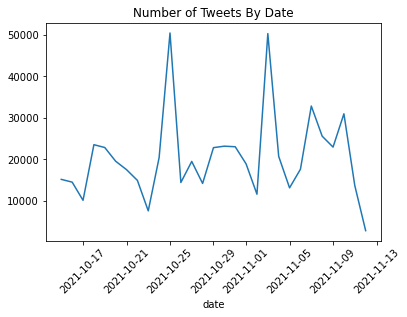

In [144]:
p_influential_date.plot(kind = 'line', x = 'date', y = 'count(text)', \
                     title = 'Number of Tweets By Date', legend = None)
plt.xticks(rotation=45)

### Location

In [79]:
import geopandas
from shapely.geometry import Point
import matplotlib.pyplot as plt

In [81]:
coord = df3.select('coord').dropna()

In [77]:
coord.count()

1731

In [82]:
coord = coord.toPandas()

In [83]:
coord['coord1'] = [tuple(lst) for lst in coord.coord]

In [84]:
coord['coord1'] = coord['coord1'].apply(Point)

In [85]:
gdf = geopandas.GeoDataFrame(coord, geometry='coord1')

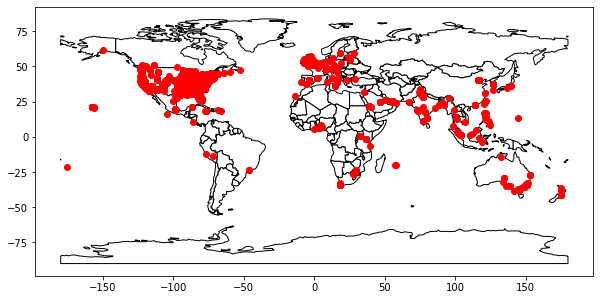

In [90]:
world = geopandas.read_file(geopandas.datasets.get_path('naturalearth_lowres'))

# We restrict to South America.
ax = world.plot(
    color='white', edgecolor='black', figsize = (10, 5))

# We can now plot our GeoDataFrame.
gdf.plot(ax=ax, color='red')

plt.show()

### Tweet Volumes by Organization

#### Government

In [43]:
tweet_volume_gov = df2.filter(df2.organization == 'Governmental').groupBy('username').agg(count('text')).\
    orderBy('count(text)', ascending = False)

In [44]:
display(tweet_volume_gov)

username,count(text)
Heerak Christian ...,442
#IndiaFightsCorona,269
Martin Cowen,212
Phil News Agency,209
David Rider,205
ORF,187
Shawn Cabbagestalk,168
Marc Lobliner,156
Asher Wolf,149
PIB in Maharashtr...,147


#### News

In [46]:
tweet_volume_news = df2.filter(df2.organization == 'News').groupBy('username').agg(count('text')).\
    orderBy('count(text)', ascending = False)

In [47]:
display(tweet_volume_news)

username,count(text)
Hindustan Times,1566
TOI Cities,867
Stuff,849
Reuters,821
ABS-CBN News,801
Inquirer,624
CNN Philippines,596
ABC News,591
NDTV,577
The Straits Times,560


#### Health

In [48]:
tweet_volume_health = df2.filter(df2.organization == 'Health').groupBy('username').agg(count('text')).\
    orderBy('count(text)', ascending = False)

In [ ]:
display(tweet_volume_health)

#### Celebrity 

In [30]:
tweet_volume_celebrity = df2.filter(df2.organization == 'Celebrity').groupBy('username').agg(count('text')).\
    orderBy('count(text)', ascending = False)

In [ ]:
display(tweet_volume_celebrity)

#### Influencer

In [31]:
tweet_volume_influencer = df2.filter(df2.organization == 'Influencer').groupBy('username').agg(count('text')).\
    orderBy('count(text)', ascending = False)

In [ ]:
display(tweet_volume_influencer)

#### Other

In [ ]:
tweet_volume_influencer = df2.filter(df2.organization == 'Other').groupBy('username').agg(count('text')).\
    orderBy('count(text)', ascending = False)

In [ ]:
display(tweet_volume_other)

## Retweet Count 

In [33]:
retweet_count_user = df2.groupBy('username').agg(sum('retweet_count2')).orderBy('sum(retweet_count2)', ascending = False)

In [34]:
display(retweet_count_user)

username,sum(retweet_count2)
.,22831011
ً,10378146
J,7280810
David,6859580
Chris,6487281
John,6231946
Mike,6063668
Alex,5946921
🦋,5500833
Michael,5462263


In [ ]:
retweet_count_org = df2.groupBy('organization').agg(sum('retweet_count2')).orderBy('sum(retweet_count2)', ascending = False)

In [ ]:
display(retweet_count_org)

#### Government

In [35]:
retweet_count_gov = df2.filter(df2.organization == 'Governmental').\
    groupBy('username').agg(sum('retweet_count2')).orderBy('sum(retweet_count2)', ascending = False)

In [36]:
display(retweet_count_gov)

username,sum(retweet_count2)
Martin Cowen,117559
David Rider,82821
Marc Lobliner,52690
Kelly McCullough,51106
Anita Snow,46469
Mayor Patrick Madden,46323
Rep Brianna Titon...,44615
kandacereddtv,43699
Sheila Jackson Lee,43211
Eliza Orlins,41206


#### News

In [ ]:
retweet_count_news = df2.filter(df2.organization == 'News').\
    groupBy('username').agg(sum('retweet_count2')).orderBy('sum(retweet_count2)', ascending = False)

In [ ]:
display(retweet_count_news)

#### Healthcare

In [ ]:
retweet_count_health = df2.filter(df2.organization == 'Health').\
    groupBy('username').agg(sum('retweet_count2')).orderBy('sum(retweet_count2)', ascending = False)

In [ ]:
display(retweet_count_health)

#### Celebrity

In [ ]:
retweet_count_celebrity = df2.filter(df2.organization == 'Celebrity').\
    groupBy('username').agg(sum('retweet_count2')).orderBy('sum(retweet_count2)', ascending = False)

In [ ]:
display(retweet_count_celebrity)

#### Influencer

In [ ]:
retweet_count_influencer = df2.filter(df2.organization == 'Celebrity').\
    groupBy('username').agg(sum('retweet_count2')).orderBy('sum(retweet_count2)', ascending = False)

In [ ]:
display(retweet_count_influencer)

#### Other

In [ ]:
retweet_count_other = df2.filter(df2.organization == 'Other').\
    groupBy('username').agg(sum('retweet_count2')).orderBy('sum(retweet_count2)', ascending = False)

In [ ]:
display(retweet_count_other)

## Location 

### Tweet Location (More Specific by US State)

In [48]:
tweet_volume_loc = df2.groupBy('location')

In [49]:
#df2.select('location').show(500, False)

In [50]:
#df2.groupBy('location').count().orderBy('count', ascending = False).show(500)

In [51]:
df2 = df2.withColumn('location1', lower(df2.location))

In [110]:
df2 = df2.withColumn('location2', 
                    F.when((df2.location1.contains('uk')) | (df2.location1.contains('united kingdom')) \
                           | (df2.location1.contains('england')) | (df2.location1.contains('london')) \
                           | (df2.location1.contains('glasgow')) | (df2.location1.contains('liverpool')) \
                           | (df2.location1.contains('birmingham')) | (df2.location1.contains('edinburgh')) \
                           | (df2.location1.contains('scottland')) | (df2.location1.contains('wales')) \
                           | (df2.location1.contains('ireland')) | (df2.location1.contains('u.k')) \
                           | (df2.location1.contains('oxford')) | (df2.location1.contains('bristol')) \
                           | (df2.location1.contains('essex')) | (df2.location1.contains('surrey')) \
                           | (df2.location1.contains('sussex')), 'UK' ) \
                     .when((df2.location1.contains('ny')) | (df2.location1.contains('new york')) \
                           | (df2.location1.contains('nyc')) | (df2.location1.contains('buffalo')) \
                           | (df2.location1.contains('albany')) | (df2.location1.contains('rochester')) \
                           | (df2.location1.contains('troy')), 'US - New York' ) \
                     .when((df2.location1.contains('tx')) | (df2.location1.contains('texas')) \
                           | (df2.location1.contains('houston')) | (df2.location1.contains('austin')) \
                           | (df2.location1.contains('dallas')) | (df2.location1.contains('arlington')) \
                           | (df2.location1.contains('san antonio')), 'US - Texas')\
                     .when((df2.location1.contains('florida')) | (df2.location1.contains('fl')) \
                           | (df2.location1.contains('jacksonville')) | (df2.location1.contains('tampa')) \
                           | (df2.location1.contains('miami')) | (df2.location1.contains('tallahassee')), 'US - Florida') \
                     .when((df2.location1.contains('california')) | (df2.location1.contains('ca')) \
                           | (df2.location1.contains('los angeles')) | (df2.location1.contains('la')) \
                           | (df2.location1.contains('san diego')) | (df2.location1.contains('san francisco')) \
                           | (df2.location1.contains('san jose')) | (df2.location1.contains('fresno')) \
                           | (df2.location1.contains('irvine')), 'US - California') \
                     .when((df2.location1.contains('illinois')) | (df2.location1.contains('chicago')) \
                           | (df2.location1.contains('naperville')) | (df2.location1.contains('springfield')) \
                           | (df2.location1.contains('rockford')) | (df2.location1.contains('champaign')), 'US - Illinois') \
                     .when((df2.location1.contains('dc')) | (df2.location1.contains('washington')), 'US - DC') \
                     .when((df2.location1.contains('pennsylvania')) | (df2.location1.contains('pa')) \
                           | (df2.location1.contains('philadelphia')) | (df2.location1.contains('pittsburgh')), 'US - Pennsylvania') \
                     .when((df2.location1.contains('usa')) | (df2.location1.contains(' us ')) | (df2.location1.contains('united states')) \
                           | (df2.location1.contains('carolina')) | (df2.location1.contains('virginia')) \
                           | (df2.location1.contains('new jersey')) | (df2.location1.contains('georgia')) \
                           | (df2.location1.contains('ohio')) | (df2.location1.contains('michigan')) \
                           | (df2.location1.contains('louisiana')) | (df2.location1.contains('indiana')) \
                           | (df2.location1.contains('missouri')) | (df2.location1.contains('kansas')) \
                           | (df2.location1.contains('massachusetts')) | df2.location1.contains('arizona') \
                           | (df2.location1.contains('boston')) | (df2.location1.contains('seattle')) \
                           | (df2.location1.contains('wa')) | (df2.location1.contains('ma'))\
                           | (df2.location1.contains('az')) | (df2.location1.contains('va')) \
                           | (df2.location1.contains('nj')) | (df2.location1.contains('al')) \
                           | (df2.location1.contains('ak')) | (df2.location1.contains('as')) \
                           | (df2.location1.contains('ar')) | (df2.location1.contains('co')) \
                           | (df2.location1.contains('ct')) | (df2.location1.contains('de')) \
                           | (df2.location1.contains('ga')) | (df2.location1.contains('in')) \
                           | (df2.location1.contains('ks')) | (df2.location1.contains('la')) \
                           | (df2.location1.contains('md')) | (df2.location1.contains('mi')) \
                           | (df2.location1.contains('mn')) | (df2.location1.contains('mo')) \
                           | (df2.location1.contains('nv')) | (df2.location1.contains('nc')) \
                           | (df2.location1.contains('oh')) | (df2.location1.contains('ky')) \
                           | (df2.location1.contains('tn')) | (df2.location1.contains('u.s.a')) \
                           | (df2.location1.contains('tennessee')) | (df2.location1.contains('id')) \
                           | (df2.location1.contains('hi')) | (df2.location1.contains('ok')) \
                           | (df2.location1.contains('sc')), 'USA - other') \
                     .when((df2.location1.contains('canada')) | (df2.location1.contains('ontario')) \
                           | (df2.location1.contains('ottawa')) | (df2.location1.contains('toronto')) \
                           | (df2.location1.contains('quebec')) | (df2.location1.contains('montreal')), 'Canada') \
                     .when((df2.location1.contains('india')) | (df2.location1.contains('delhi')) \
                           | (df2.location1.contains('mumbai')) | (df2.location1.contains('bengaluru')) \
                           | (df2.location1.contains('kolkata')) | (df2.location1.contains('jaipur')) \
                           | (df2.location1.contains('chennai')), 'India') \
                     .when((df2.location1.contains('australia')) | (df2.location1.contains('melbourne')) \
                           | (df2.location1.contains('sydney')) | (df2.location1.contains('brisbane')), 'Australia')\
                     .when((df2.location1.contains('europe')) | (df2.location1.contains('European Union')) \
                           | (df2.location1.contains('eu')) | (df2.location1.contains('belgium')) \
                           | (df2.location1.contains('brussels')) | (df2.location1.contains('amsterdam')), 'Europe') \
                     .when((df2.location1.contains('nigeria')) | (df2.location1.contains('ghana')) \
                           | (df2.location1.contains('nairobi')), 'Africa') \
                     .when(df2.location1.contains('earth'), 'Earth')\
                     .otherwise(df2.location)
                    )

In [111]:
display(df2)

created_at,id_str,text,entities,user,retweeted_status,retweet_count,favorite_count,quote_count,lang,name,location,favorites_count2,followers_count2,statuses_count2,coord,retweet_count2,quote_count2,verified,screen_name,username,year,month,week_day,day,new_date,date_form,date,description,description2,organization,retweet_quote,location1,location2
Fri Oct 22 21:38:...,1451664177727221765,RT @AllisonPearso...,"[[],, [], [], [[1...","[false, Fri Mar 2...","[,, Fri Oct 22 21...",0,0,0,en,ekleston,United Kingdom,4095,92,3098,null,146,13,false,ekleston,Freamons wire,2021,Oct,Fri,22,2021-Oct-22,2021-10-22,2021-10-22,"Dad, husband, son...","dad, husband, son...",Other,159,united kingdom,UK
Fri Oct 22 21:38:...,1451664177441951752,@TheLastLeg #Boos...,"[[[[12, 26], Boos...","[false, Tue Apr 2...",null,0,0,0,en,BeckiJo60105430,"West Midlands, En...",274,13,65,null,0,0,false,BeckiJo60105430,Becki Johnson,2021,Oct,Fri,22,2021-Oct-22,2021-10-22,2021-10-22,Keep your face to...,keep your face to...,Other,0,"west midlands, en...",UK
Fri Oct 22 21:38:...,1451664178096320518,Sexton closed aft...,"[[],, [], [[rssfe...","[false, Mon Sep 1...",null,0,0,0,en,freep,Detroit,5848,496741,287181,null,0,0,true,freep,Detroit Free Press,2021,Oct,Fri,22,2021-Oct-22,2021-10-22,2021-10-22,News & analysis f...,news & analysis f...,News,0,detroit,USA - other
Fri Oct 22 21:38:...,1451664178515697673,RT @geezerpaulr: ...,"[[],, [], [], [[9...","[false, Mon Nov 0...","[,, Fri Oct 22 21...",0,0,0,en,fulltimedogmum,null,19816,1423,7155,null,6,0,false,fulltimedogmum,Full Time Dog Mum,2021,Oct,Fri,22,2021-Oct-22,2021-10-22,2021-10-22,Stop the world I ...,stop the world i ...,Other,6,null,null
Fri Oct 22 21:38:...,1451664178222182404,RT @AllisonPearso...,"[[],, [], [], [[1...","[false, Tue Mar 0...","[,, Fri Oct 22 21...",0,0,0,en,GunCulture,"Cumberland, England",23023,401,9415,null,147,13,false,GunCulture,Rusty Shackleford...,2021,Oct,Fri,22,2021-Oct-22,2021-10-22,2021-10-22,She-she-sshhaa! ...,she-she-sshhaa! ...,Other,160,"cumberland, england",UK
Fri Oct 22 21:38:...,1451664178796769288,RT @PeterSweden7:...,"[[],, [], [], [[7...","[false, Mon Sep 0...","[,, Fri Oct 22 21...",0,0,0,en,WaitingGame2021,null,536,8,35,null,96,10,false,WaitingGame2021,Waiting Game,2021,Oct,Fri,22,2021-Oct-22,2021-10-22,2021-10-22,Nothing makes me ...,nothing makes me ...,Other,106,null,null
Fri Oct 22 21:38:...,1451664180084453376,RT @YALiberty: Yo...,"[[],, [], [], [[1...","[false, Sun Sep 0...","[,, Thu Oct 21 20...",0,0,0,en,Disugeorge,null,86551,491,68375,null,359,21,false,Disugeorge,Diana George,2021,Oct,Fri,22,2021-Oct-22,2021-10-22,2021-10-22,"wife, mom and gra...","wife, mom and gra...",Other,380,null,null
Fri Oct 22 21:38:...,1451664180247924739,RT @globalhlthtwi...,"[[],, [], [], [[8...","[false, Tue Oct 0...","[,, Fri Oct 22 15...",0,0,0,en,readthinkwalk,Milton Keynes,29175,345,27919,null,531,33,false,readthinkwalk,Mal Smith,2021,Oct,Fri,22,2021-Oct-22,2021-10-22,2021-10-22,"http://M.Sc., Phy...","http://m.sc., phy...",Other,564,milton keynes,USA - other
Fri Oct 22 21:38:...,1451664180977799171,RT @MichaelPSenge...,"[[],, [], [], [[1...","[false, Thu Nov 2...","[,, Fri Oct 22 20...",0,0,0,en,ChordSounds,"Kendal, England",11407,236,5764,null,213,36,false,ChordSounds,Common Sense Chord,2021,Oct,Fri,22,2021-Oct-22,2021-10-22,2021-10-22,Trying To Find Sa...,trying to find sa...,Other,249,"kendal, england",UK
Fri Oct 22 21:38:...,1451664180910641153,RT @AllisonPearso...,"[[],, [], [], [[1...","[false, Tue Jun 0...","[,, Fri Oct 22 21...",0,0,0,en,John50213207,null,64513,2432,79620,null,164,18,false,John50213207,John,2021,Oct,Fri,22,2021-Oct-22,2021-10-22,2021-10-22,null,null,Other,182,null,null


In [159]:
#df2.groupBy('location2').agg(count('text')).orderBy('count(text)')

In [160]:
## Distribution of all tweet volume by location 

tweet_vol_loc = df2.groupBy('location2').agg(count('text')).orderBy('count(text)', ascending = False)

In [161]:
display(tweet_vol_loc)

location2,count(text)
null,6363828
USA - other,3953595
US - California,2206251
UK,1371206
US - New York,399680
US - Texas,334073
US - Florida,311107
US - Pennsylvania,268520
US - DC,116447
US - Illinois,36276


In [196]:
tweet_vol_loc =tweet_vol_loc.filter(tweet_vol_loc.location2.isNotNull())

In [201]:
import databricks.koalas as ks

In [204]:
kdf = ks.DataFrame(tweet_vol_loc)

In [205]:
kdf1 = kdf[0:10]

/usr/lib/spark/python/pyspark/sql/pandas/functions.py:383: UserWarning: In Python 3.6+ and Spark 3.0+, it is preferred to specify type hints for pandas UDF instead of specifying pandas UDF type which will be deprecated in the future releases. See SPARK-28264 for more details.
  warnings.warn(


In [206]:
p_tweet_vol_loc = kdf1.toPandas()

<AxesSubplot:title={'center':'Number of Tweets by Location'}, xlabel='location2'>

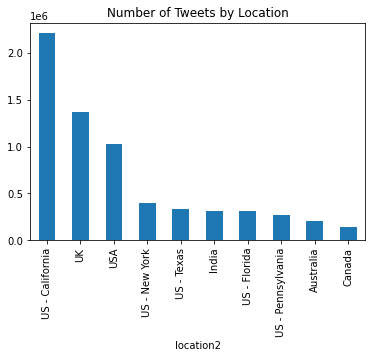

In [207]:
p_tweet_vol_loc.plot(kind = 'bar', x = 'location2', y = 'count(text)', \
                     title = 'Number of Tweets by Location', legend = None)

### Overall Tweet Volume Dates

In [219]:
# Number of tweets by date 
tweets_by_date = df3.groupBy('date').agg(count('text')).orderBy('date', ascending = True)

In [220]:
tweets_by_date.show(20, False)

+----------+-----------+
|date      |count(text)|
+----------+-----------+
|2021-10-15|546782     |
|2021-10-16|512782     |
|2021-10-17|488255     |
|2021-10-18|836064     |
|2021-10-19|753893     |
|2021-10-20|798375     |
|2021-10-21|732953     |
|2021-10-22|637778     |
|2021-10-23|492551     |
|2021-10-24|482548     |
|2021-10-25|601518     |
|2021-10-26|625645     |
|2021-10-27|619624     |
|2021-10-28|555292     |
|2021-10-29|560905     |
|2021-10-30|453505     |
|2021-10-31|461839     |
|2021-11-01|588760     |
|2021-11-02|547855     |
|2021-11-03|670809     |
+----------+-----------+
only showing top 20 rows



In [221]:
p_tweets_by_date = tweets_by_date.toPandas()

In [222]:
%matplotlib inline
import pandas as pd
import matplotlib.pyplot as plt

(array([18917., 18921., 18925., 18929., 18932., 18936., 18940., 18944.]),
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

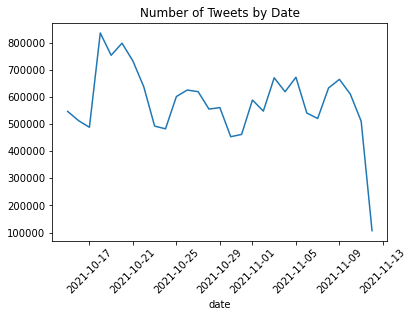

In [225]:
p_tweets_by_date.plot(kind = 'line', x = 'date', y = 'count(text)', \
                     title = 'Number of Tweets by Date', legend = None)
plt.xticks(rotation=45)